In [7]:
%load_ext autoreload
%autoreload 2
import os

import pandas as pd
from python.analysis import Plots, cross_section
from python.analysis.shower_merging import SetPlotStyle
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, erf
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp

from rich import print

SetPlotStyle()


def figure_dimensions(x, orientation : str = "horizontal"):
    nearest_square = int(np.ceil(x**0.5))

    if x < 4:
        dim = (1, x)
    elif (nearest_square - 1) * nearest_square >= x:
        dim = ((nearest_square - 1), nearest_square)
    else:
        dim = (nearest_square, nearest_square)
    
    if orientation == "vertical":
        dim = dim[::-1]
    return dim


def Hist2DComparison(x, y, x_range, y_range, x_labels = None, y_labels = None, titles = None, bins = 50, cmap = "plasma", func = None, orientation = "horizontal"):
    if x_labels is None: x_labels = [""]*len(x)
    if y_labels is None: y_labels = [""]*len(y)
    if titles is None: titles = [""] * len(x)

    dim = figure_dimensions(len(x), orientation)
    fig_size = (6.4 * dim[1], 4.8 * dim[0])
    ranges = [x_range, y_range]

    vmax = 0
    for xs, ys in zip(x, y):
        h, _, _ = np.histogram2d(xs, ys, bins, range = ranges)
        vmax = max(vmax, np.max(h))

    fig = plt.figure(figsize = fig_size)
    for i in range(len(x)):
        plt.subplot(*dim, i + 1)
        if func is None:
            _, _, _, im = plt.hist2d(x[i], y[i], bins, range = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        else:
            _, _, _, im = func(x = x[i], y = y[i], bins = bins, ranges = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        plt.xlabel(x_labels[i])
        plt.ylabel(y_labels[i])
        plt.title(titles[i])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.subplots_adjust(right=0.84)
    fig.colorbar(im, cax = cbar_ax)


def LinearFit(x, m):
    return m * x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_hdf("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5", "all_photons")
df["residual"] = df.reco_energy - df.true_energy
df["fractional_error"] = (df.reco_energy / df.true_energy) - 1
print(df)

path = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/"
save = False

if save is True:
    os.makedirs(path, exist_ok = True)

reco_energy  true_energy  true_mother     residual  fractional_error
0       133.802572   268.863259          111  -135.060687         -0.502340
1       127.616533  1343.636619          211 -1216.020086         -0.905022
2       104.872036   129.958027          111   -25.085991         -0.193031
3        75.675744    89.715949          111   -14.040205         -0.156496
4       563.250869   770.033836          111  -206.782967         -0.268538
...            ...          ...          ...          ...               ...
16581   545.426464   531.016507          111    14.409957          0.027137
16582   516.226603   335.723310          111   180.503293          0.537655
16583   565.426627   385.056909          111   180.369718          0.468424
16584    35.134860    90.807447          111   -55.672587         -0.613084
16585   246.498951   420.794547          111  -174.295596         -0.414206

[16586 rows x 5 columns]

[111]

{'pi0_daughter': 13922, 'other': 0}

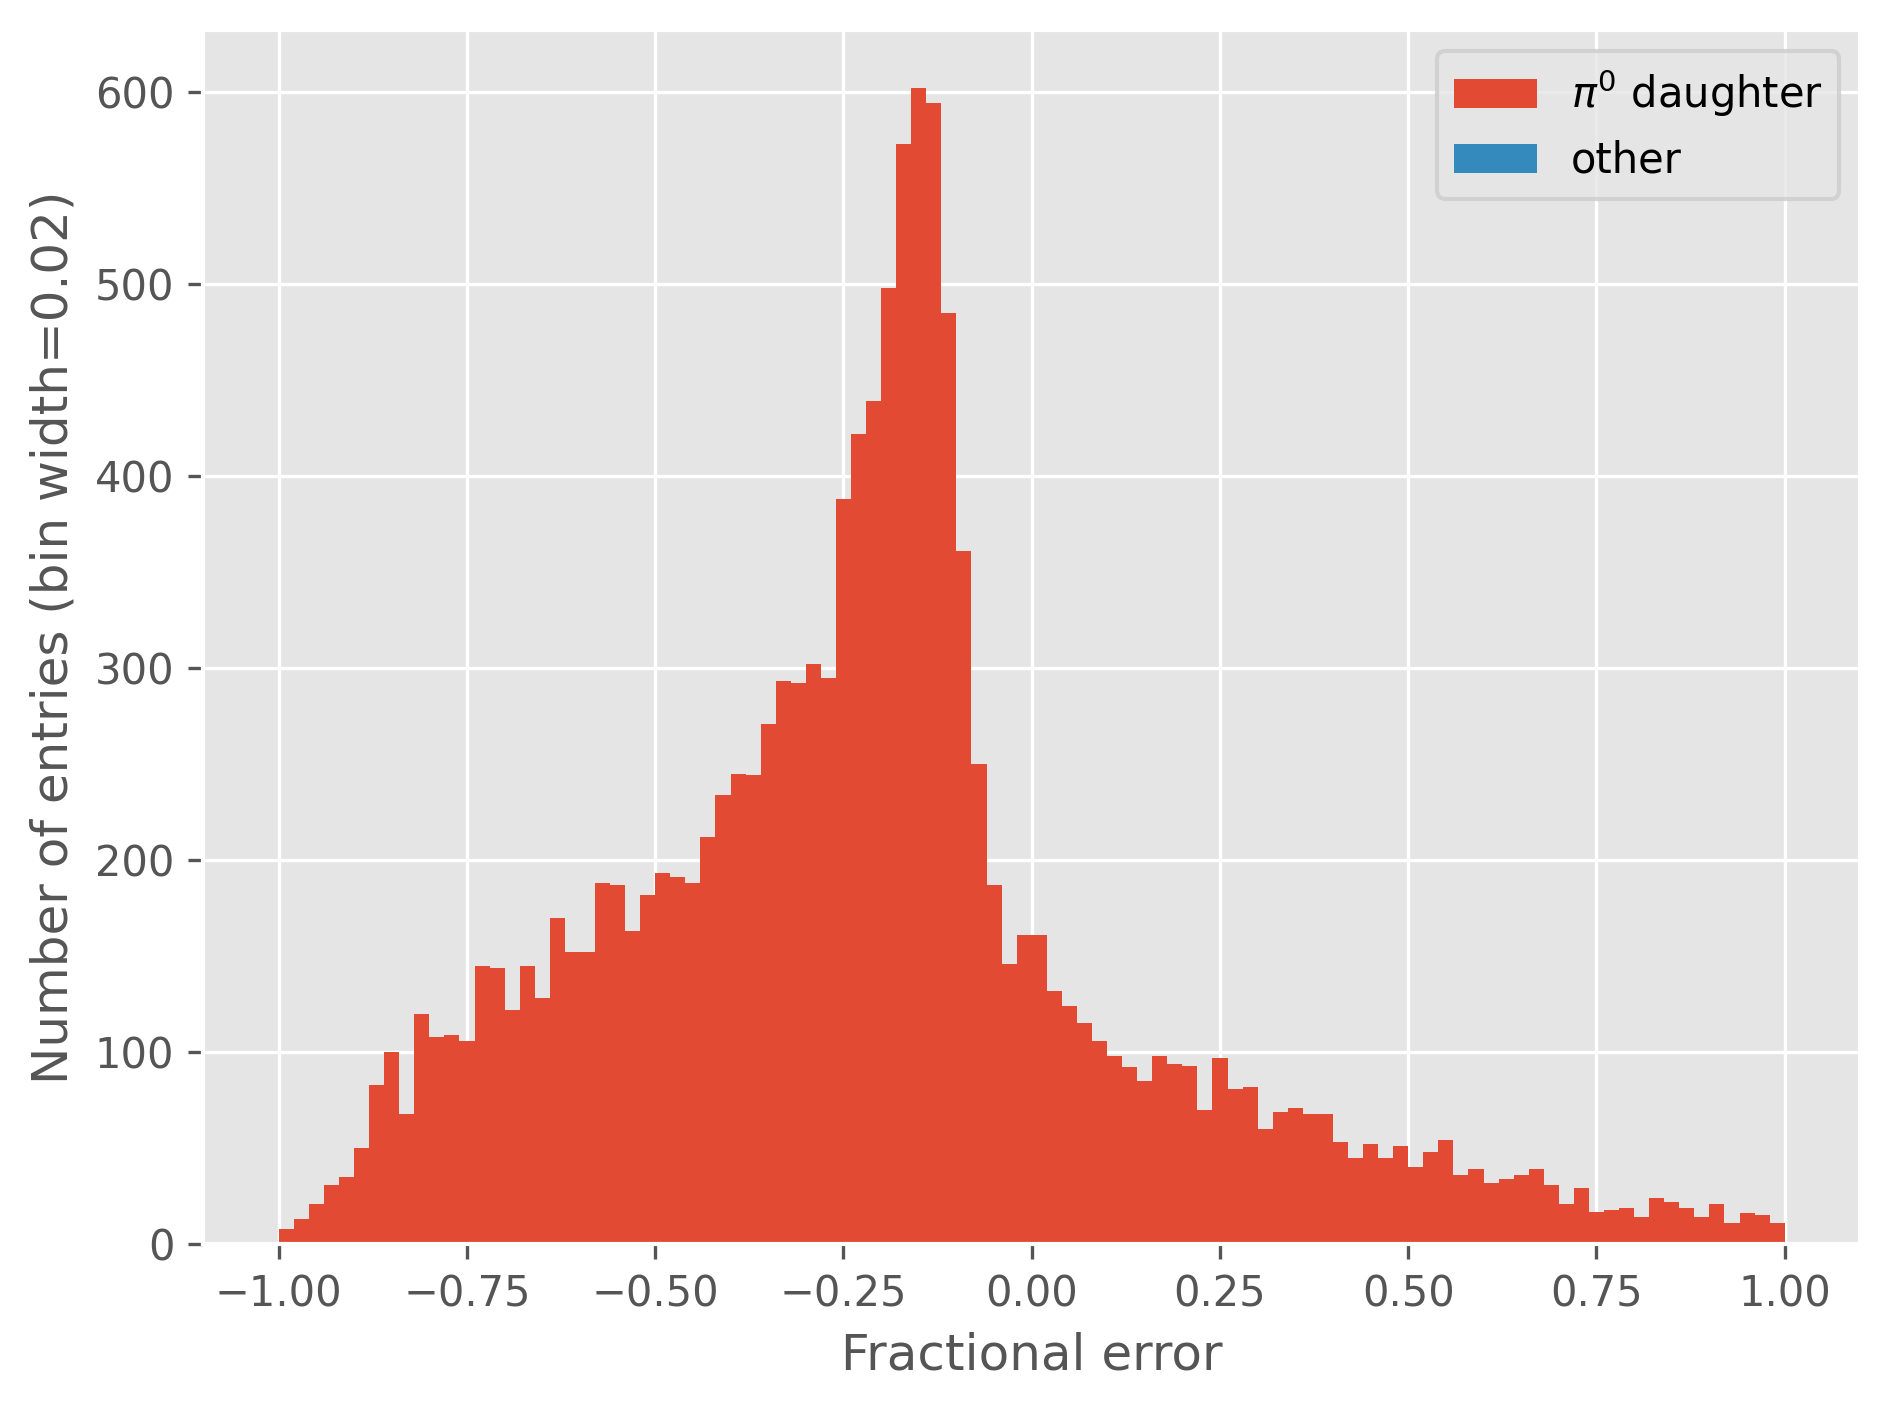

In [8]:
print(np.unique(df.true_mother))

pi0_mother = df.true_mother == 111

counts = {"pi0_daughter" : len(pi0_mother[pi0_mother]), "other" : len(pi0_mother) - len(pi0_mother[pi0_mother])}

print(counts)

Plots.PlotHist([df[pi0_mother].fractional_error, df[~pi0_mother].fractional_error], stacked = True, range = [-1, 1], xlabel = "Fractional error", label = ["$\pi^{0}$ daughter", "other"])
if save is True: Plots.Save("fraction_error_stacked", path)

df = df[pi0_mother]

energy_range = (0, 1500)

In [9]:
def binned_dataframe(bins : list) -> list:
    binned_data = []
    for i in range(1, len(bins)):
        data = df[(df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])]
        binned_data.append(data[data.true_energy < max(energy_range)])
    return binned_data

# Linear Correction

In [10]:
def linear_fit(bins : list) -> float:
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array([d.true_energy.mean() for d in binned_dataframe(bins)])

    popt, pcov = curve_fit(LinearFit, x, y)

    print(popt, pcov**0.5)
    perr = np.array([pcov[i][i] for i in range(len(popt))])**0.5

    Plots.Plot(x, y, marker = "x", linestyle = "")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit")
    plt.fill_between(x, LinearFit(x, *(popt + perr)), LinearFit(x, *(popt - perr)), color = "C3", alpha = 0.5)
    Plots.Plot(x, x, newFigure = False, label = "$y = x$", xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)")
    plt.legend()


    Plots.PlotHist2D(df.true_energy, df.reco_energy, x_range = [0, 1500], y_range = [0, 1500], cmap = "summer")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit", color = "C0")
    Plots.Plot(x, x, newFigure = False, color = "black", label = "$y = x$")
    Plots.Plot(x, y, marker = "x", linestyle = "", ylabel = "True shower energy (MeV)", xlabel = "Reco shower energy (MeV)", newFigure = False, color = "C0")
    if save is True: Plots.Save("linear_correction_fit", path)
    return popt[0]


def LinearFitPerformance(linear_correction : float):
    corrected_energy = cross_section.EnergyCorrection.LinearCorrection(df.reco_energy, linear_correction)

    fe = (df.reco_energy / df.true_energy) - 1
    fec = (corrected_energy / df.true_energy) - 1

    print(f"correction factor : {linear_correction}")
    print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
    print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")

    Plots.PlotHistComparison([df.reco_energy, corrected_energy], labels = ["uncorrected", "corrected"], xRange = [0, 2000], xlabel = "Shower energy (MeV)")
    Plots.PlotHistComparison([df.reco_energy - df.true_energy, corrected_energy - df.true_energy], labels = ["uncorrected", "corrected"], xRange=[-500, 500], xlabel = "Shower energy residual (MeV)")
    if save is True: Plots.Save("linear_correction_residual", path)

    Hist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 2000], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*2, y_labels = ["Fractional error"]*2, titles = ["uncorrected", "corrected"])
    if save is True: Plots.Save("linear_correction_fe", path)
    return

[0.82971351] [[0.0348277]]

correction factor : 0.829713513762402

mean shower energy fractional error: -0.16237320982323436 +- 0.47217237207914

mean shower energy fractional error after correction: 0.009537359923764869 +- 0.5690788015950671

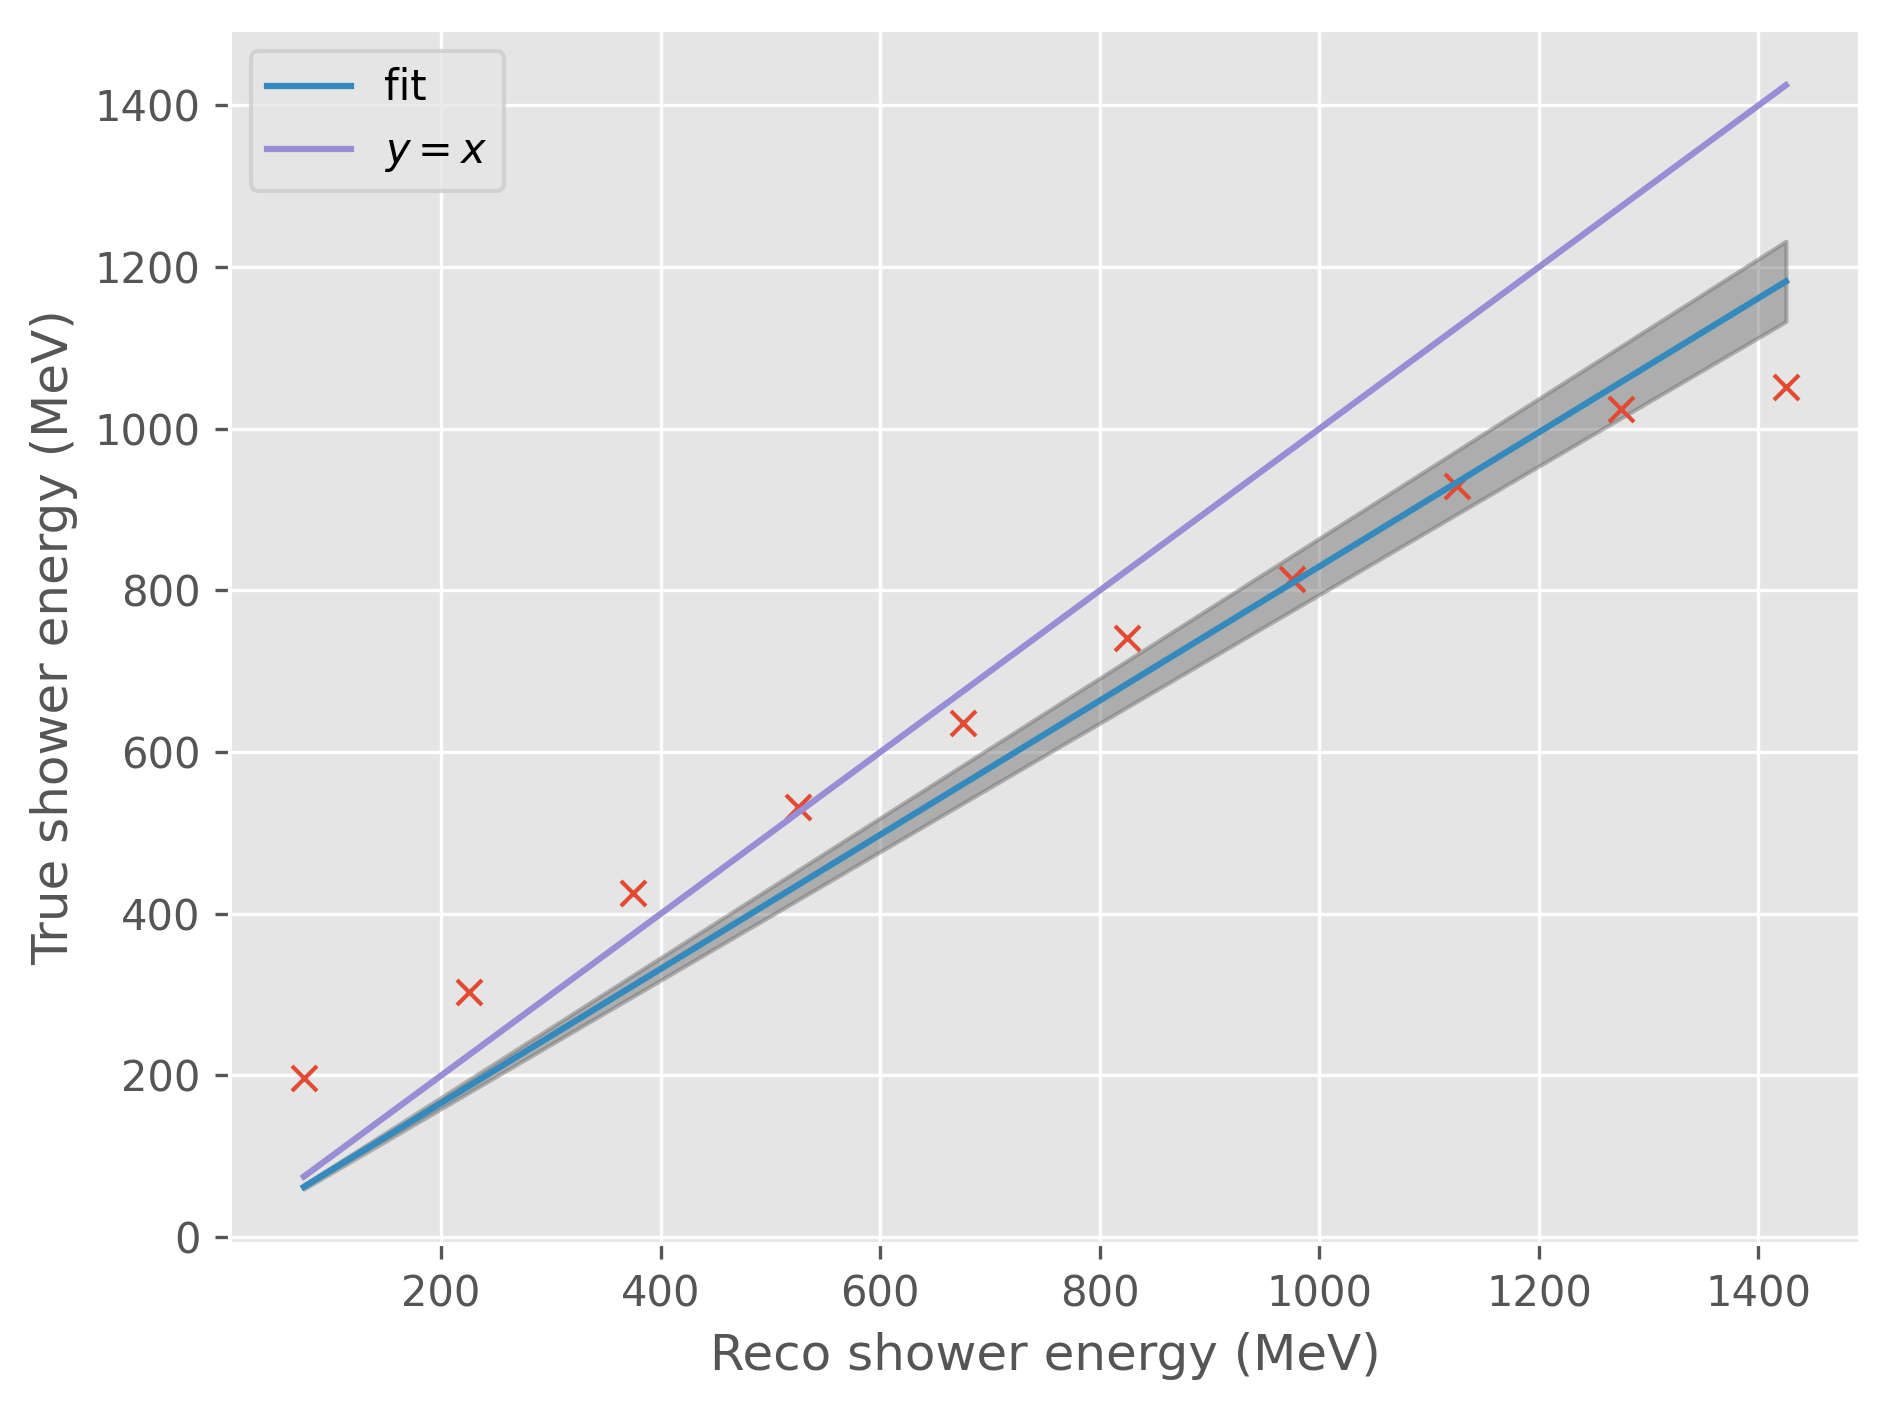

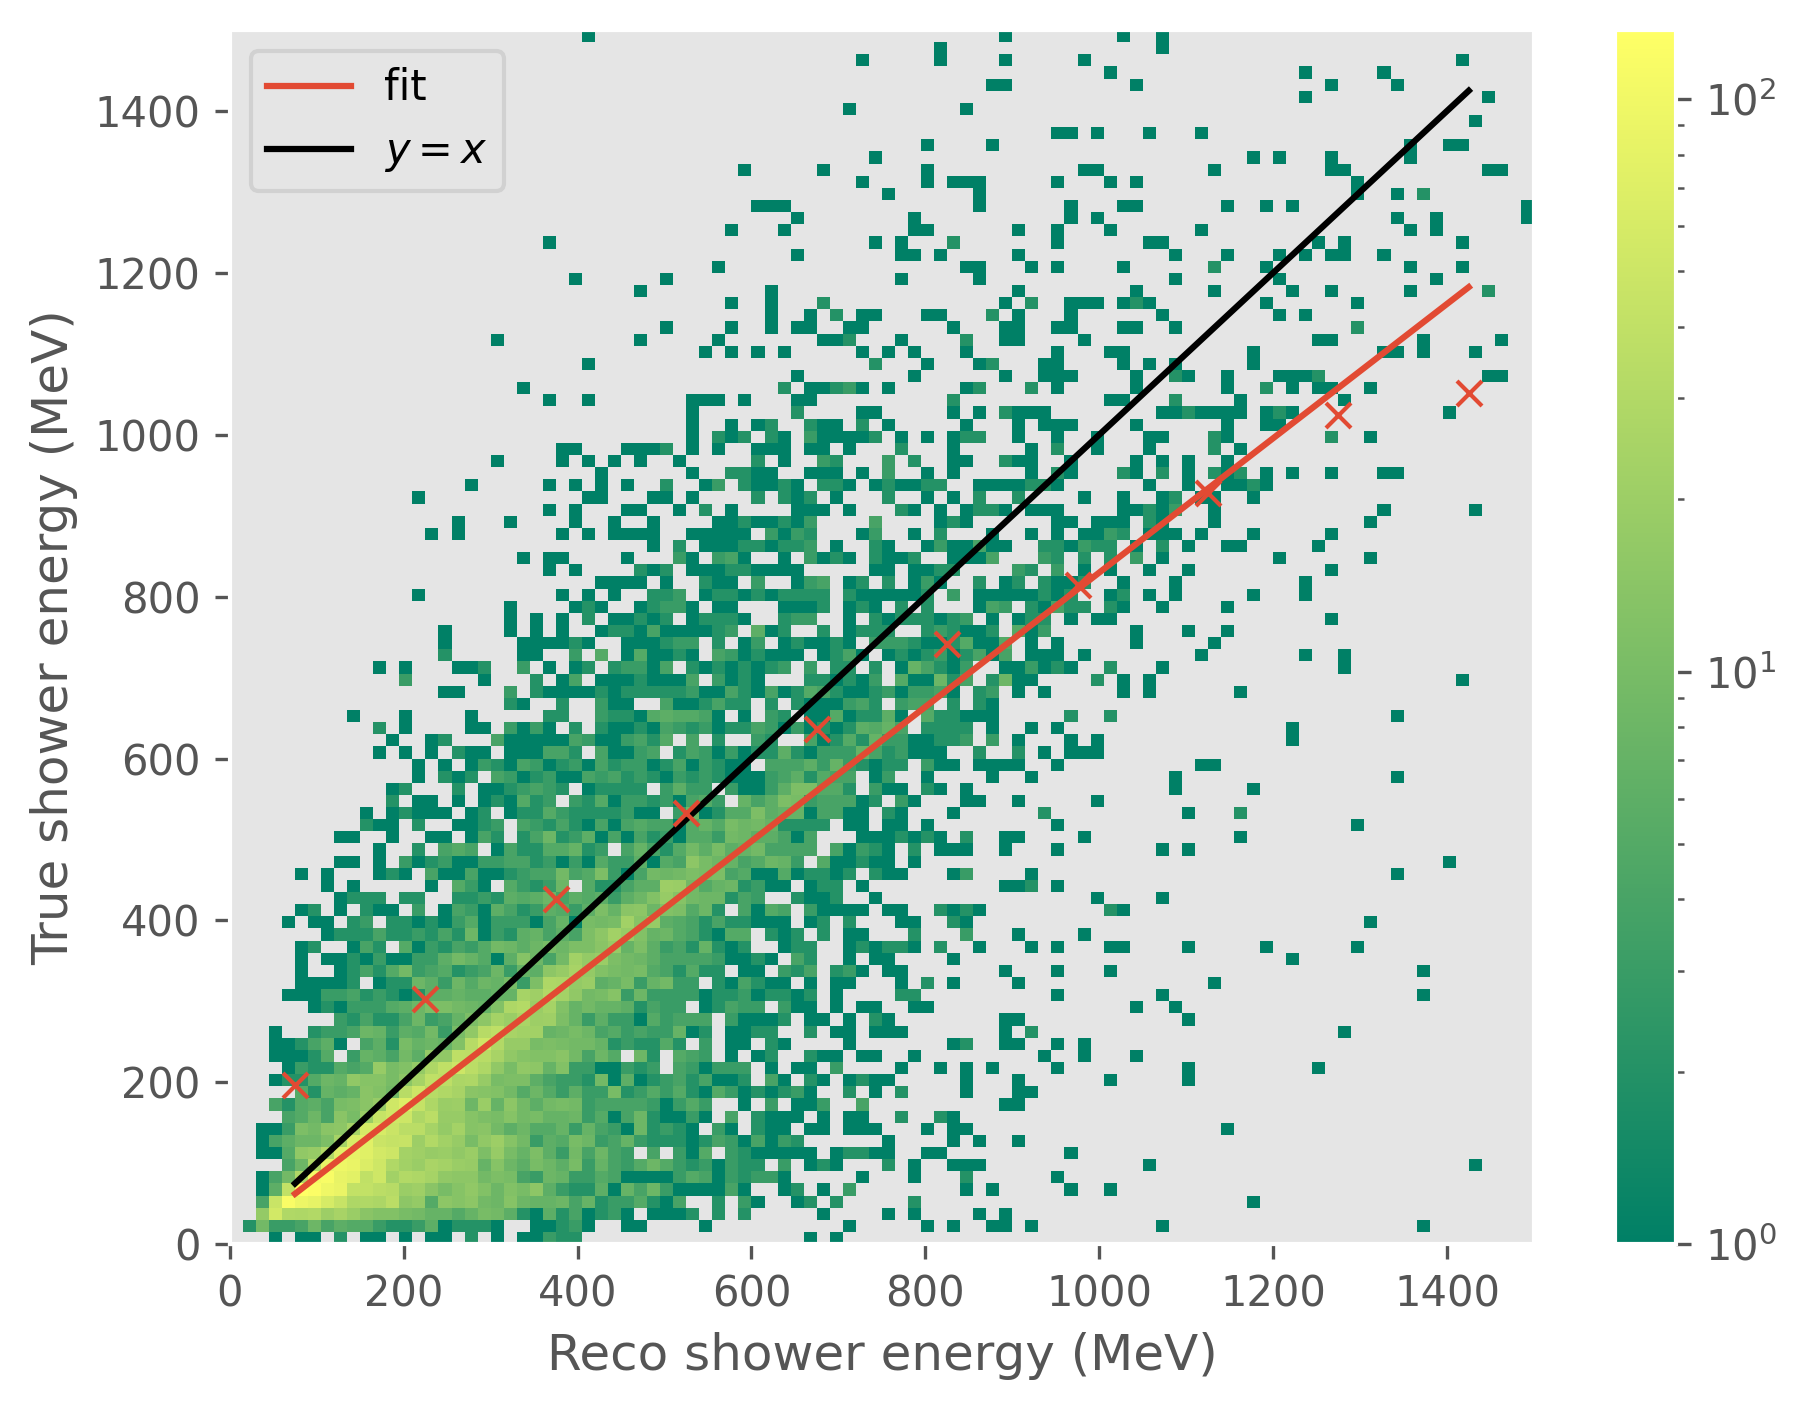

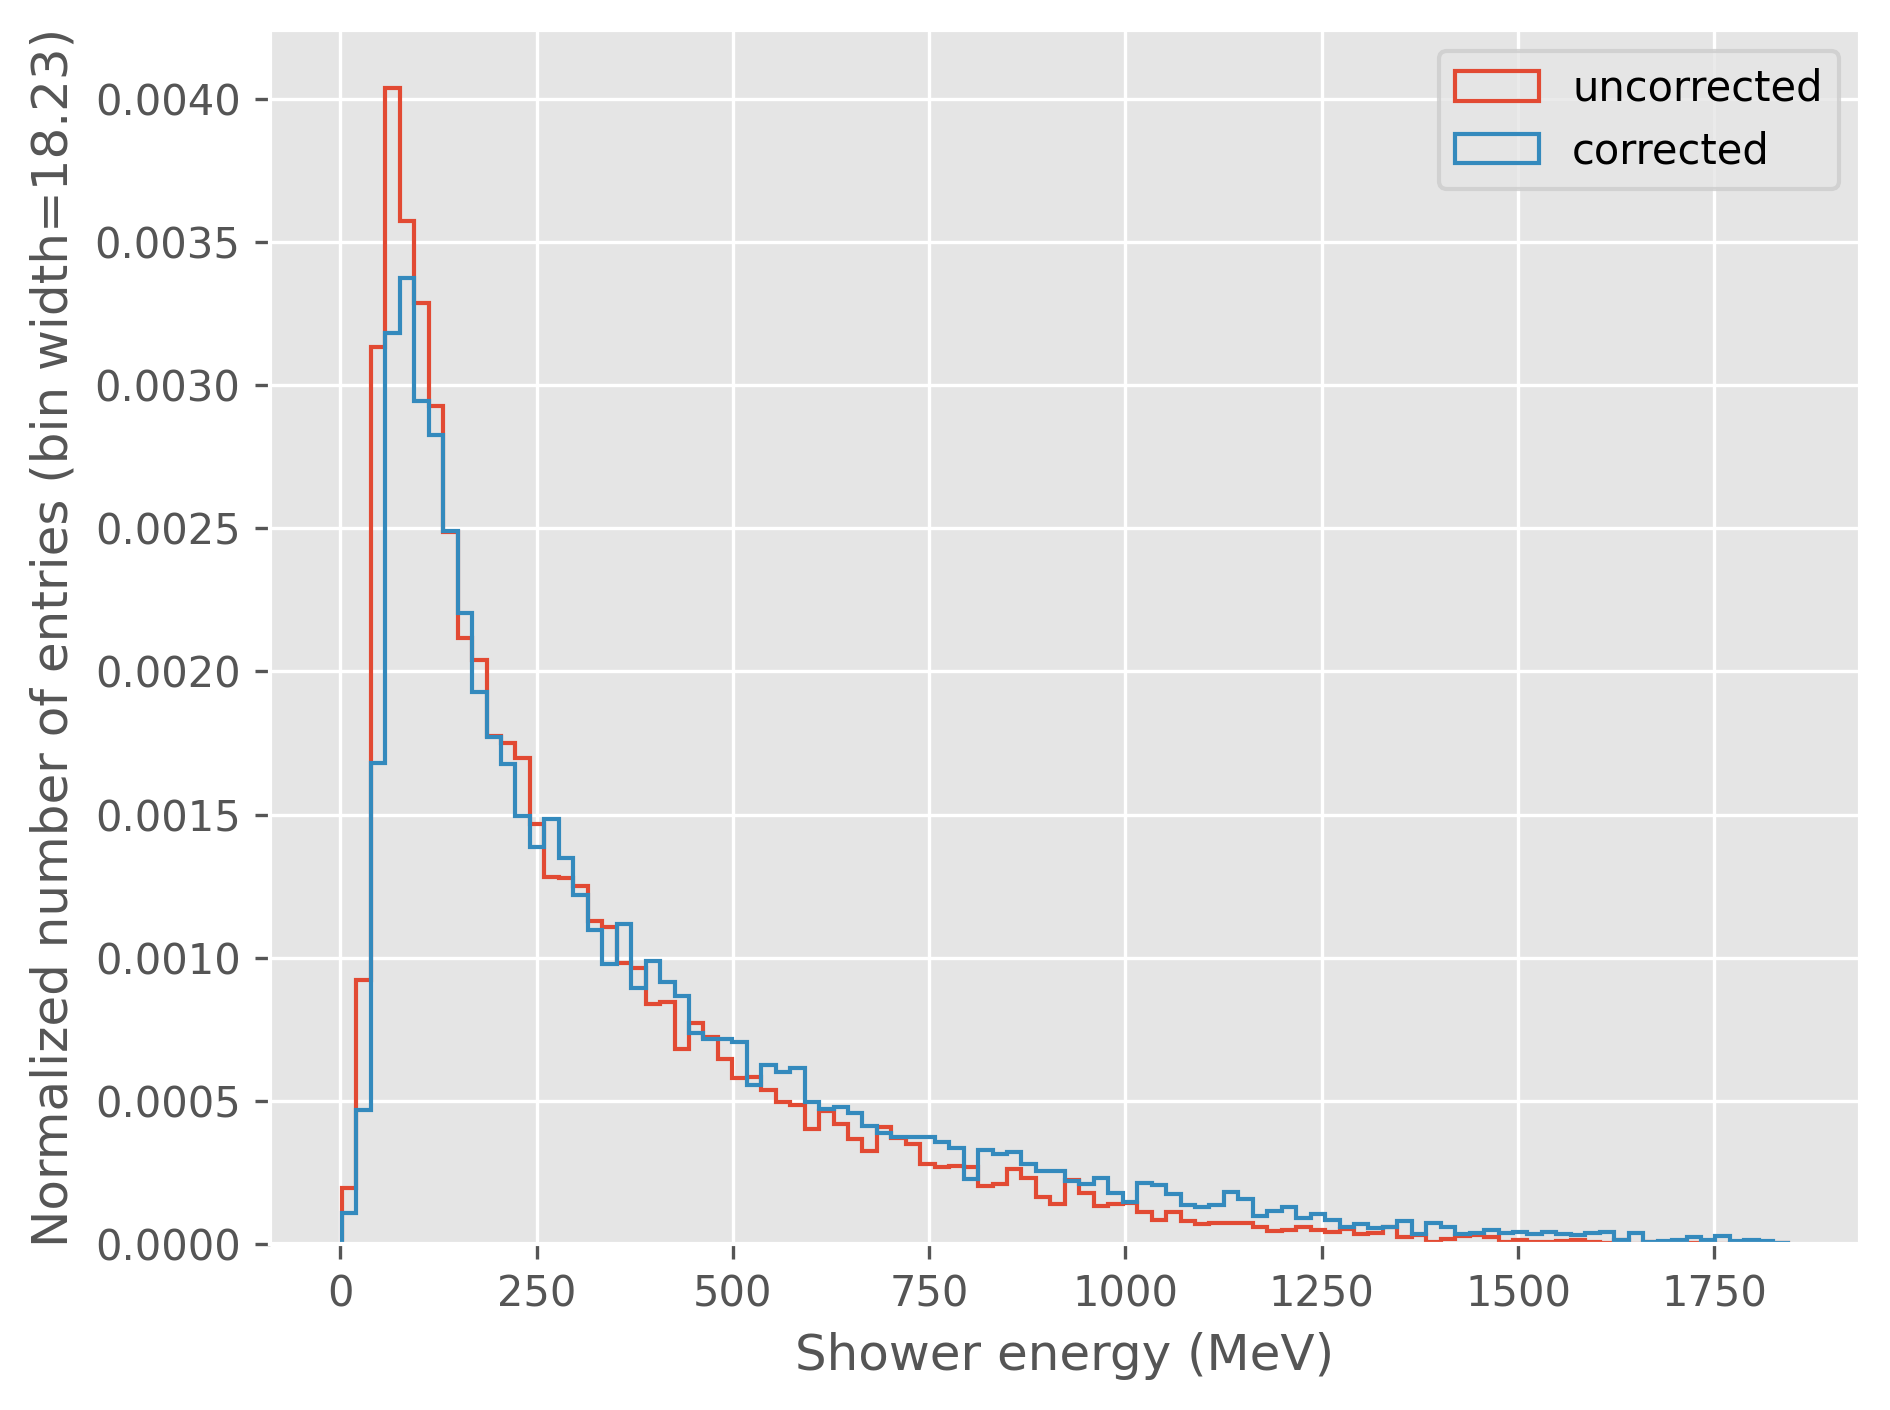

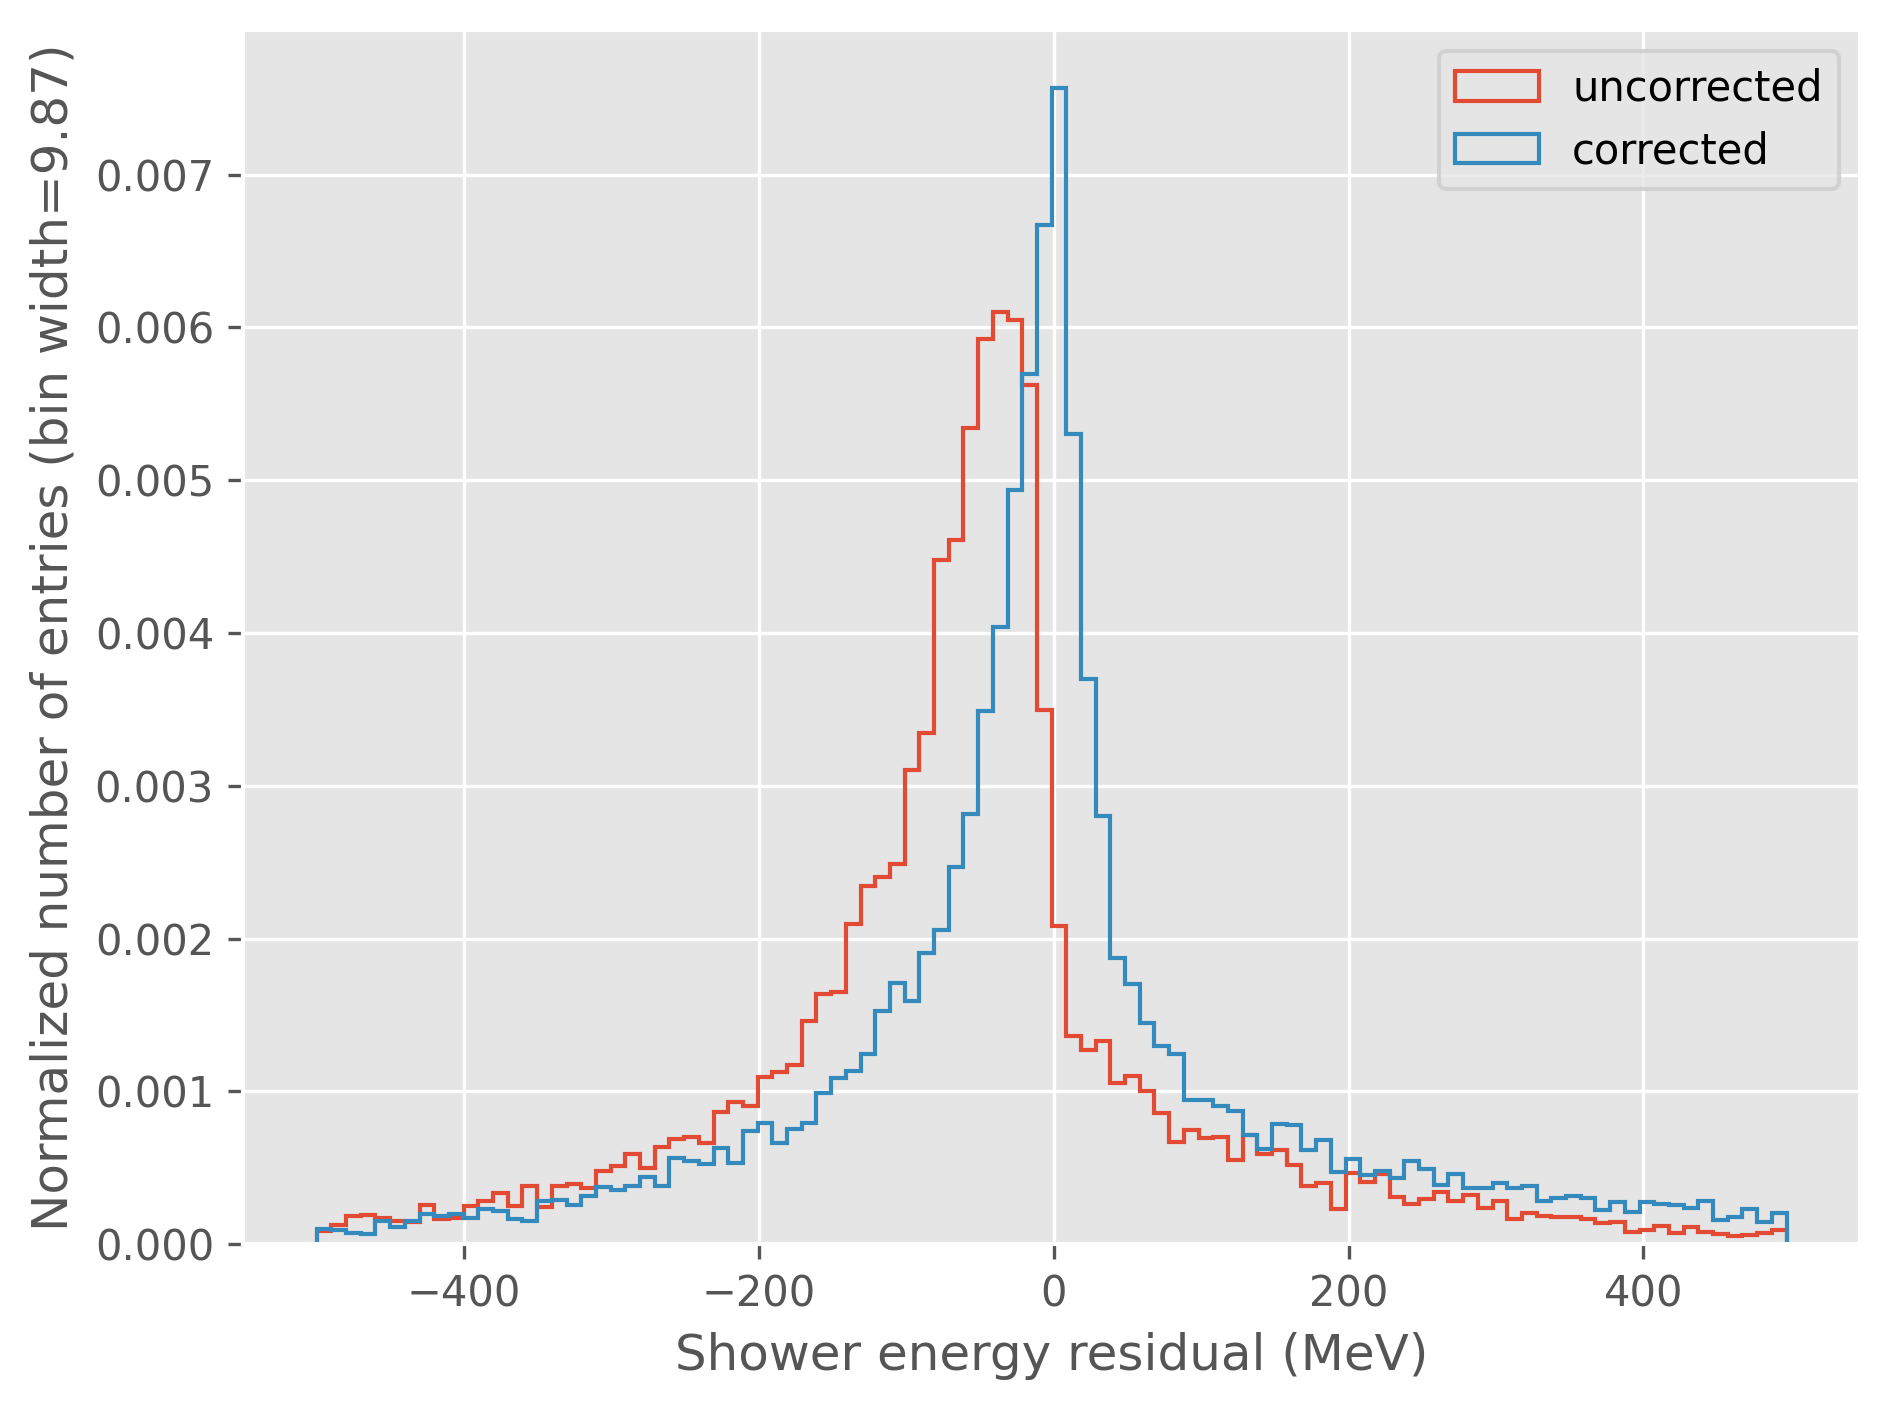

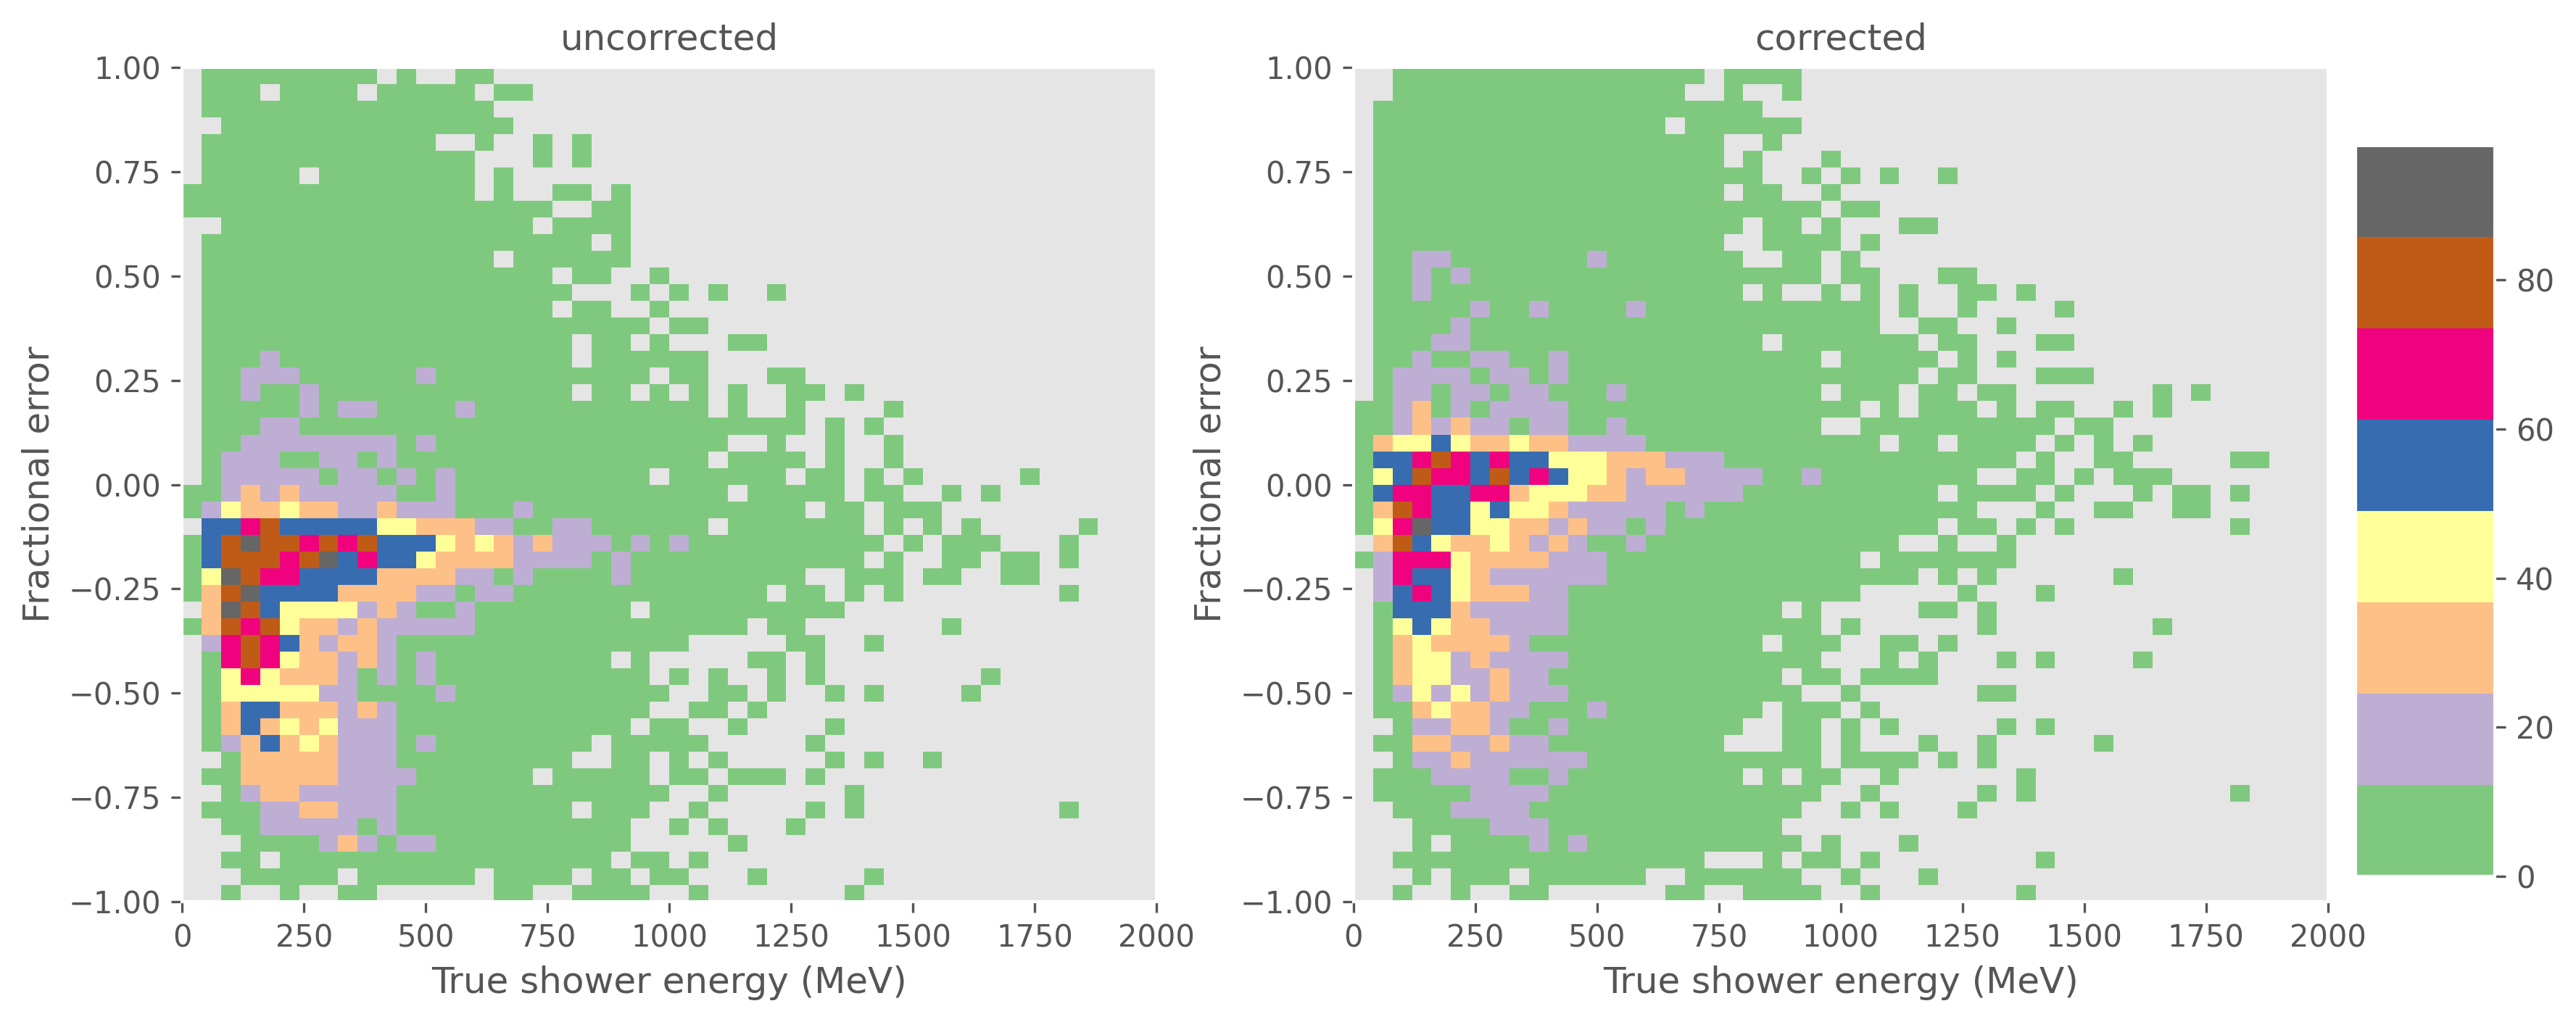

In [11]:
save = False
bins = np.linspace(min(energy_range), max(energy_range), 11)
linear_correction = linear_fit(bins)
LinearFitPerformance(linear_correction)

# Parameterised correction

In [12]:
class gaussian:
    n_params = 3

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A, mu, sigma) -> None:
        return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

    @staticmethod
    def bounds():
        return [(0, -1, 0.001), (np.inf, 1, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.median(x), np.std(x)]
    
    @staticmethod
    def mu(A, mu, sigma):
        return mu

    @staticmethod
    def var(A, mu, sigma):
        return sigma**2


class student_t:
    n_params = 4
    
    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A, mu, nu, l):
        t = (x - mu)/ l
        return (A**2 / l) * (gamma((nu + 1)/2) / (np.sqrt(nu * np.pi) * gamma(nu/2))) * (1 + t**2/nu)**(-(nu + 1)/2)

    @staticmethod
    def bounds():
        return [(0, -1, 0.01, 0.001),
                (np.inf, 1, 10, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.median(x), 2, np.std(x)]

    @staticmethod
    def mu(A, mu, nu, l):
        return mu

    @staticmethod
    def var(A, mu, nu, l):
        if nu > 2:
            return nu / (nu - 2)
        elif (nu <= 2) and nu > 1:
            return np.Inf
        else:
            return np.NaN

class double_gaussian:
    n_params = 6

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        return A_1 * np.exp(-(x - mu_1)**2 / (2 * sigma_1**2)) + A_2 * np.exp(-(x - mu_2)**2 / (2 * sigma_2**2))

    @staticmethod
    def bounds():
        return [(0     , -1, 0.001 , 0     , -1, 0.001),
                (np.inf, 1 , np.inf, np.inf, 1 , np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.mean(x), np.std(x), max(y), np.mean(x), np.std(x)]

    @staticmethod
    def mu(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)
        return (w_1 * mu_1) + (w_2 * mu_2)

    @staticmethod
    def var(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)

        return w_1 * (sigma_1**2) + w_2 * (sigma_2**2) + (w_1 * (mu_1**2) + w_2 * (mu_2**2) - (w_1*mu_1 + w_2*mu_2)**2)

class crystal_ball:
    n_params = 5

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, S, mu, sigma, alpha, n):
        t = (x - mu) / sigma

        a_alpha = abs(alpha)
        n_alpha = n / a_alpha

        A = (n_alpha)**n * np.exp(-a_alpha**2 / 2)

        B = n_alpha - a_alpha

        C = (n_alpha) * (1/(n - 1)) * np.exp(-a_alpha**2/2)

        D = np.sqrt(np.pi / 2) *(1 + erf(a_alpha/np.sqrt(2)))

        N = 1 / (C + D) # should be 1 / sigma * (C + D), but I dont want to normalise the function

        y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)
        return S * N * y

    @staticmethod
    def bounds():
        return [(0, -1, 0.001, 1, 2),
                (np.inf, 1, np.inf, 3, 10)]

    @staticmethod
    def p0(x,y):
        return [max(y), np.mean(x), np.std(x), 1, 2]

    @staticmethod
    def mu(S, mu, sigma, alpha, n):
        return mu

In [14]:
def fit_regions(variable : str, v_range : list, funcs, reco_bins : list, hist_bins : int, log : bool = False):
    def print_log(x):
        if log: print(x)
    
    dim = figure_dimensions(len(reco_bins) - 1)
    plt.subplots(*dim, figsize = (6.4 * dim[1], 4.8 * dim[0]))

    cv = []
    cv_err = []
    fig_handles = None
    fig_labels = None
    for i in range(1, len(bins)):
        print_log(i)
        binned_data = df[(df.reco_energy > bins[i-1]) & (df.reco_energy < bins[i])]
        plt.subplot(*dim, i)

        y, edges = np.histogram(binned_data[variable], bins = hist_bins, range = [min(v_range), max(v_range)])
        x = (edges[1:] + edges[:-1]) / 2
        x_interp = np.linspace(min(x), max(x), hist_bins*5)

        best_f = None
        best_popt = None
        best_perr = None
        k_best = None
        p_best = None

        for f in funcs:
            function = f()
            popt = None
            pcov = None
            perr = None
            try:
                popt, pcov = curve_fit(function.func, x, y, p0 = function.p0(x, y), method = "dogbox", bounds = function.bounds(), maxfev = 500000)
                perr = np.sqrt(np.diag(pcov))
                print_log(popt)
                print_log(perr)
                print_log(pcov)
            except:
                print_log("could not fit")
                pass
            y_pred = function.func(x, *popt) if popt is not None else None
            if y_pred is not None:
                k, p = ks_2samp(y, y_pred)
            else:
                k = 1
                p = 0

            if p_best is None or p > p_best : # larger p value suggests a better fit
                p_best = p
                k_best = k
                best_popt = popt
                best_perr = perr
                best_f = f

        mean = None
        mean_error = None
        if best_popt is not None:
            function = best_f()
            mean = function.mu(*best_popt)
            mean_error = mean - (function.mu(*(best_popt + best_perr)) + function.mu(*(best_popt + best_perr))) / 2
            y_pred = function.func(x, *best_popt)
            y_pred_interp = function.func(x_interp, *best_popt)
            k, p = ks_2samp(y, y_pred)

            Plots.Plot(x_interp, y_pred_interp, marker = "", color = "black", newFigure = False, label = "fit")
            plt.axvline(mean, color = "black", linestyle = "--", label = "central value")
        Plots.PlotHist(binned_data[variable], bins = hist_bins, newFigure = False, title = f"bin : {[reco_bins[i-1], reco_bins[i]]}", range = [min(v_range), max(v_range)])

        plt.axvline(np.mean(binned_data[variable]), linestyle = "--", color = "C1", label = "mean")

        if not fig_handles: fig_handles, fig_labels = plt.gca().get_legend_handles_labels()

        if best_popt is not None:
            text = ""
            for j in range(len(best_popt)):
                text += f"\np{j}: ${best_popt[j]:.2f}\pm${best_perr[j]:.2f}"
            text += f"\nks : {k_best:.2f}, p : {p_best:.2f}"
            legend = plt.gca().legend(handlelength = 0, labels = [text[1:]], title = best_f.__name__.replace("_", " "))
            for l in legend.legendHandles:
                l.set_visible(False)

        cv.append(mean)
        cv_err.append(abs(mean_error) if mean_error is not None else mean_error)
    
    for j in range(i, dim[0] * dim[1]):
        plt.subplot(*dim, j + 1)
        plt.gca().set_axis_off()

    plt.gcf().legend(fig_handles, fig_labels, loc = "lower right", ncols = 3)
    plt.gcf().supxlabel(variable.replace("_", " "))
    plt.tight_layout()
    if save is True : Plots.Save("binned_fits_double_gaussian", path)
    return np.array(cv), np.array(cv_err)


def calculate_mean(variable : str, v_range: list, reco_bins : list):
    means = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        means.append(ranged_data[variable].mean())
    return np.array(means)


def calculate_median(variable : str, v_range: list, reco_bins : list):
    med = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        med.append(ranged_data[variable].median())
    return np.array(med)

def calcualte_mode(variable : str, v_range: list, reco_bins : list, nbins : int):
    mode = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        # ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        heights, edges = np.histogram(binned_data[variable], nbins, range = v_range)
        centers = (edges[1:] + edges[:-1]) / 2
        mode.append(centers[np.argmax(heights)])
    return np.array(mode)

def calculate_std(variable : str, v_range: list, reco_bins : list):
    std = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        std.append(ranged_data[variable].std())
    return np.array(std)

def calculate_sem(variable : str, v_range: list, reco_bins : list):
    sem = []
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        sem.append(ranged_data[variable].std() / np.sqrt(len(ranged_data[variable])))
    return np.array(sem)


def count_entries(variable: str, v_range: list, bins : list):
    counts = []
    for i in range(1, len(bins)):
        binned_data = df[(df.reco_energy > bins[i-1]) & (df.reco_energy < bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        counts.append(len(ranged_data))
    return np.array(counts)


def create_bins(value : pd.Series, n_entries, v_range : list = None):
    sorted_value = value.sort_values()
    n_bins = len(sorted_value) // n_entries

    bins = []
    for i in range(n_bins + 1):
        mi = sorted_value.values[i * n_entries]
        bins.append(mi)
    if v_range:
        bins[0] = min(v_range)
        bins[-1] = max(v_range)
    return np.array(bins)


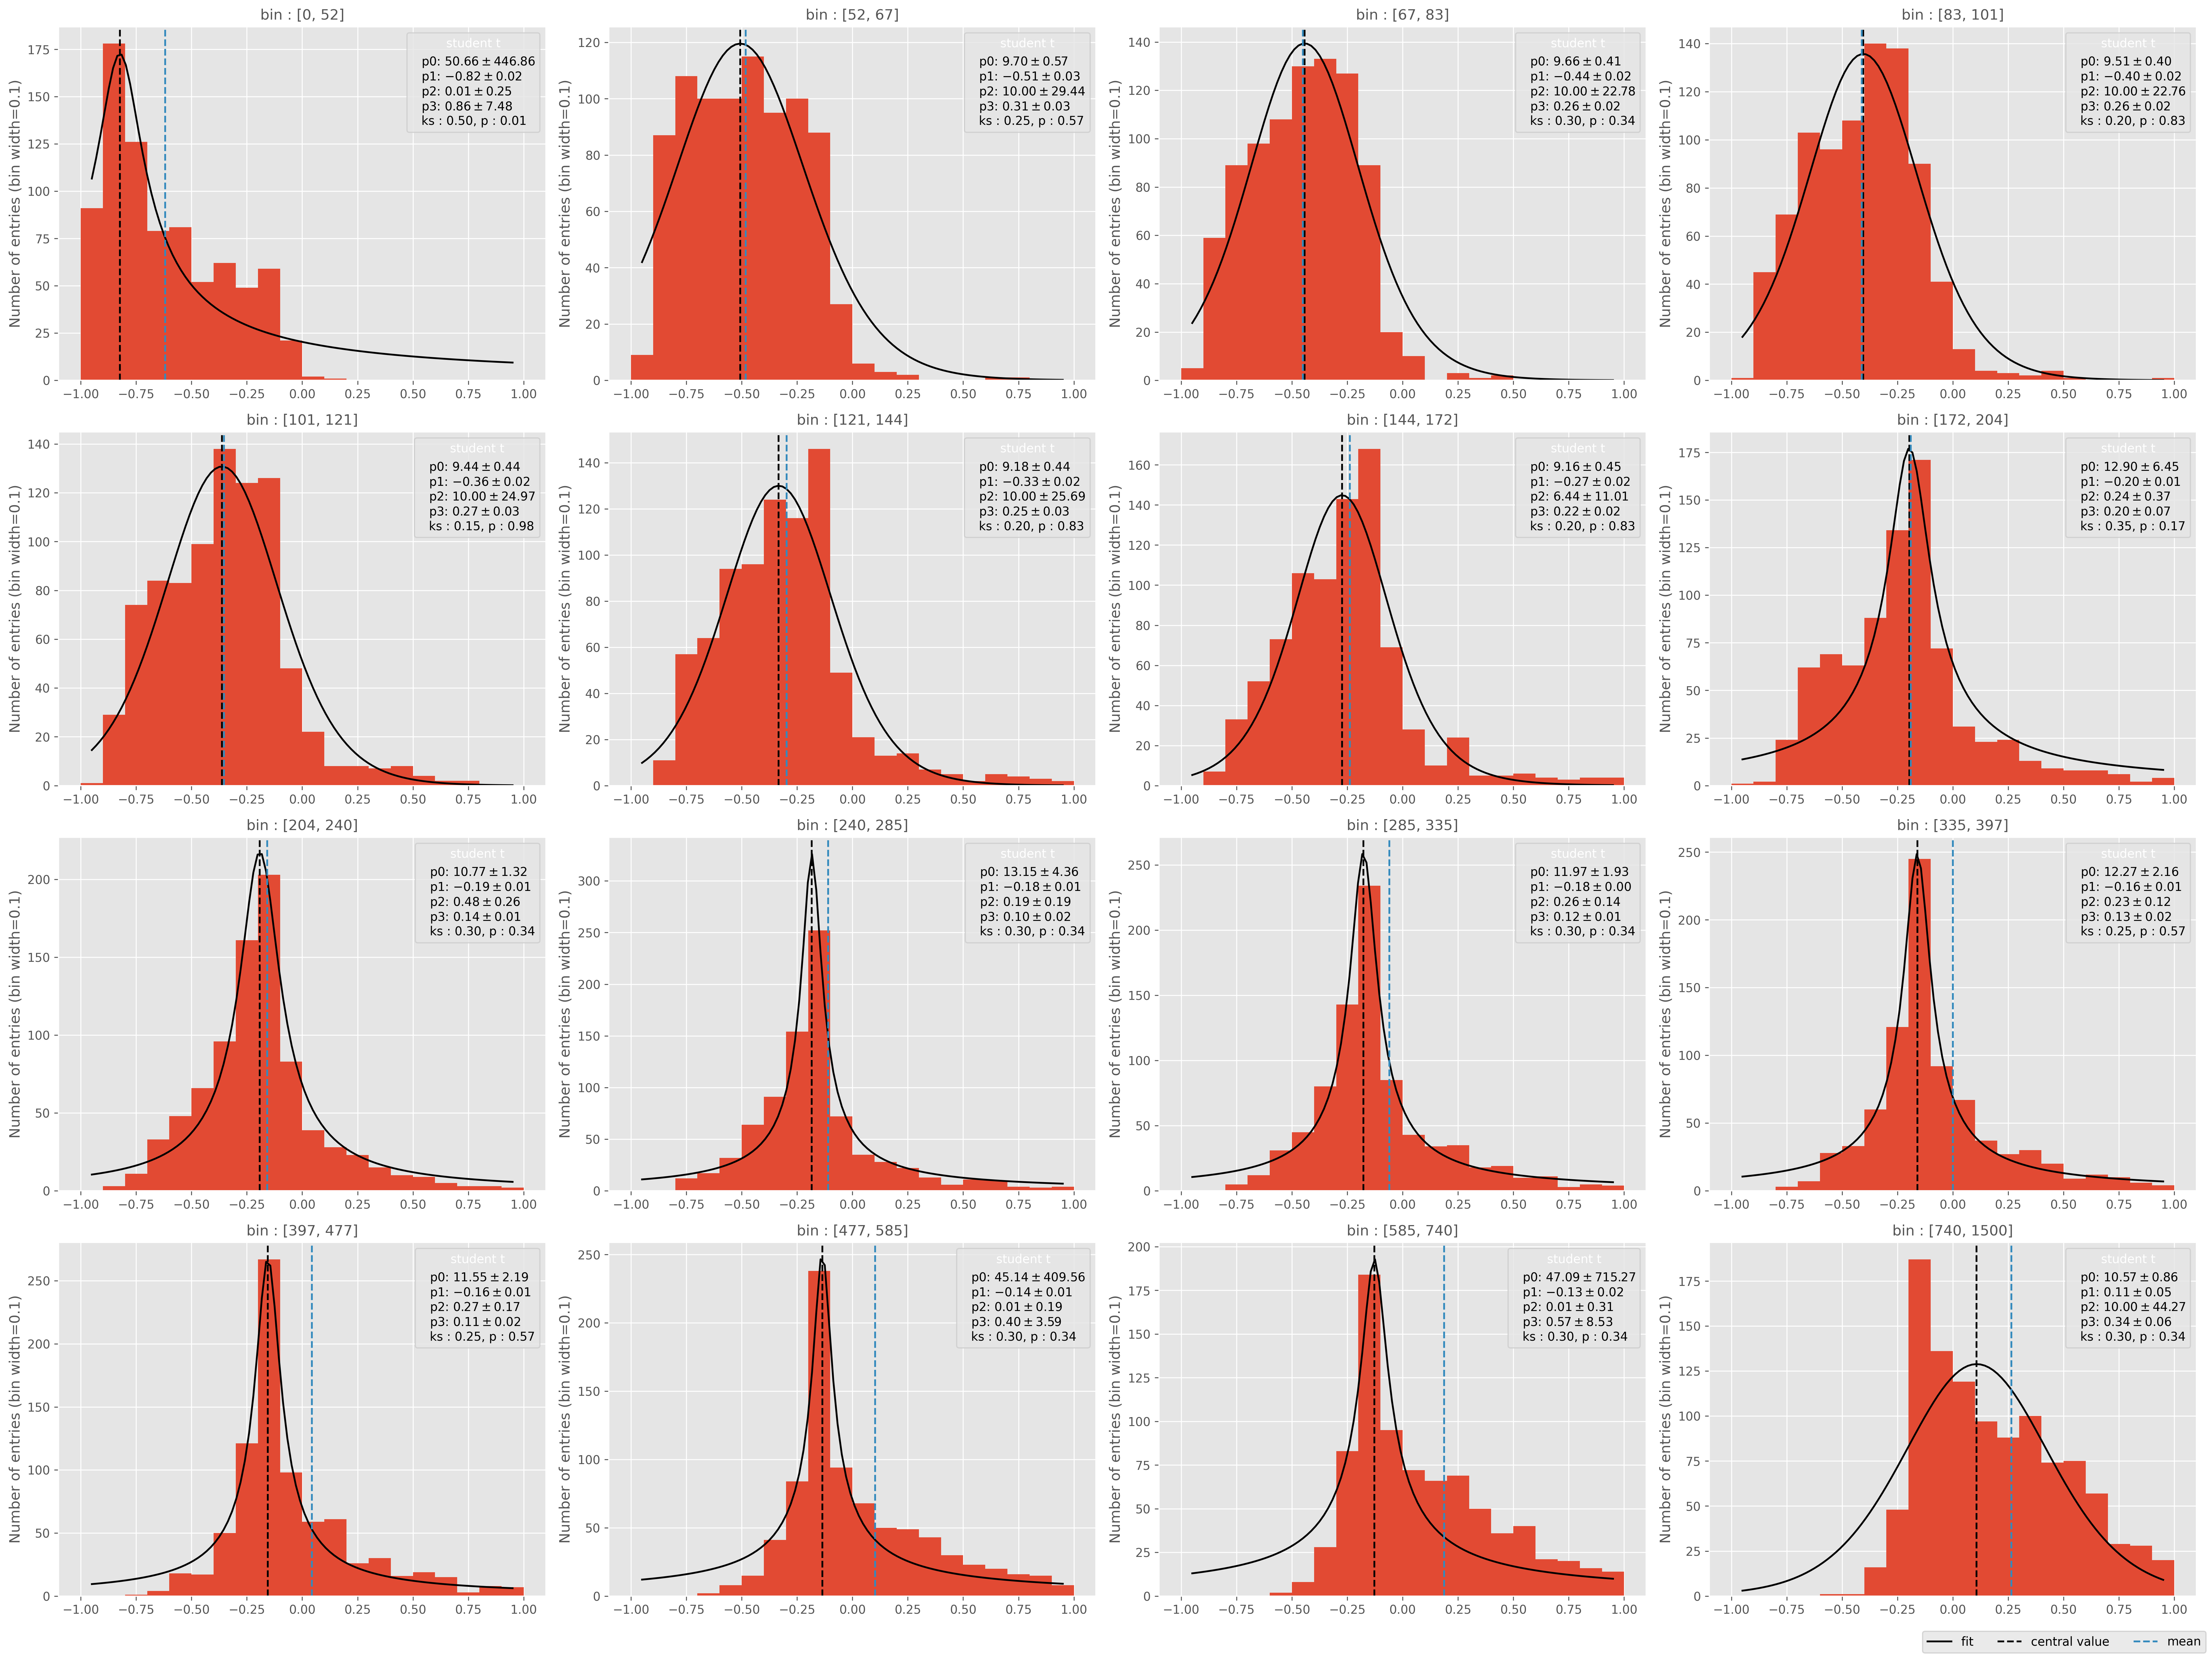

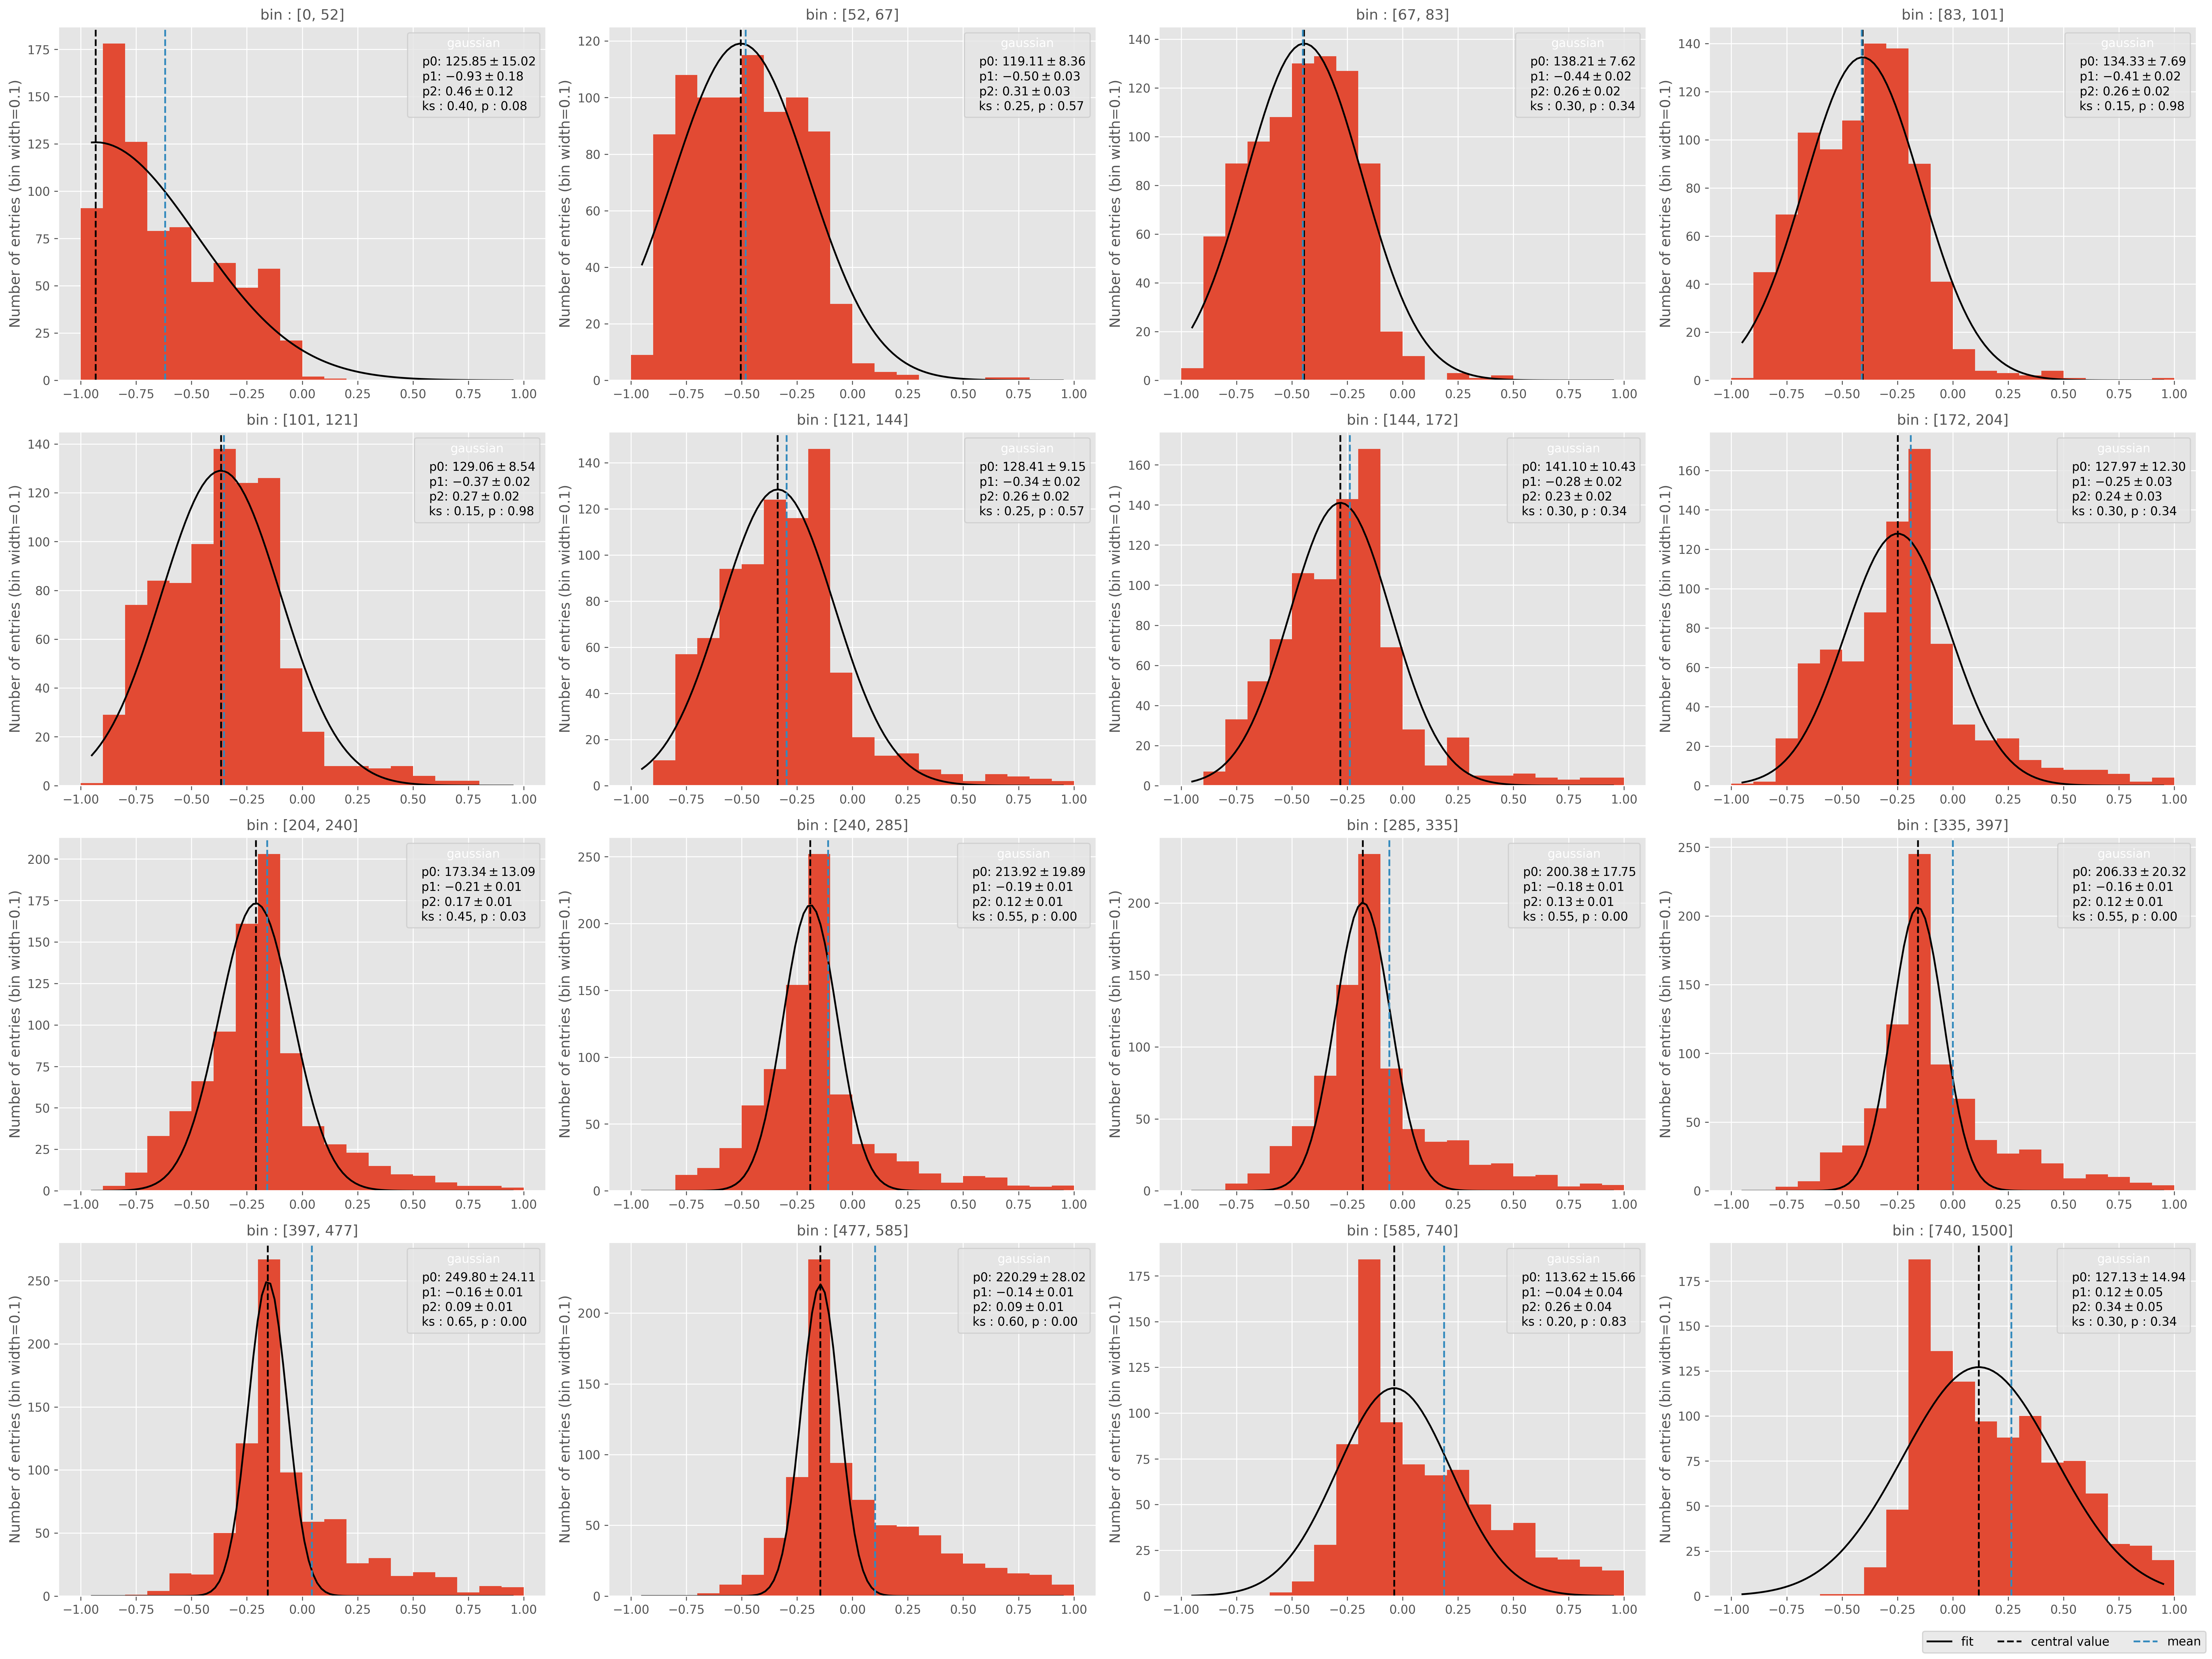

In [15]:
save = False
bins = np.array(create_bins(df.reco_energy, 850, energy_range), dtype = int)

central_values = {
    "student_t" : fit_regions("fractional_error", [-1, 1], [student_t], bins, 20),
    "gaussian" : fit_regions("fractional_error", [-1, 1], [gaussian], bins, 20),
    # "double_gaussian" : fit_regions("fractional_error", [-1, 1], [double_gaussian], bins, 20),
    "mean" : [calculate_mean("fractional_error", [-1, 1], bins), calculate_sem("fractional_error", [-1, 1], bins)]
    }

In [41]:
central_values["mode"] = [calcualte_mode("fractional_error", [-1, 1], bins, 50), calculate_sem("fractional_error", [-1, 1], bins)]
central_values.pop("mode")

[array([-0.86, -0.42, -0.3 , -0.38, -0.34, -0.14, -0.22, -0.14, -0.18,
        -0.14, -0.14, -0.14, -0.14, -0.14, -0.14, -0.14]),
 array([0.00930178, 0.00862983, 0.00784798, 0.00835573, 0.00933664,
        0.01007892, 0.00989664, 0.01083355, 0.00934676, 0.00934304,
        0.0097773 , 0.01002876, 0.00979433, 0.01105745, 0.01139622,
        0.00968928])]

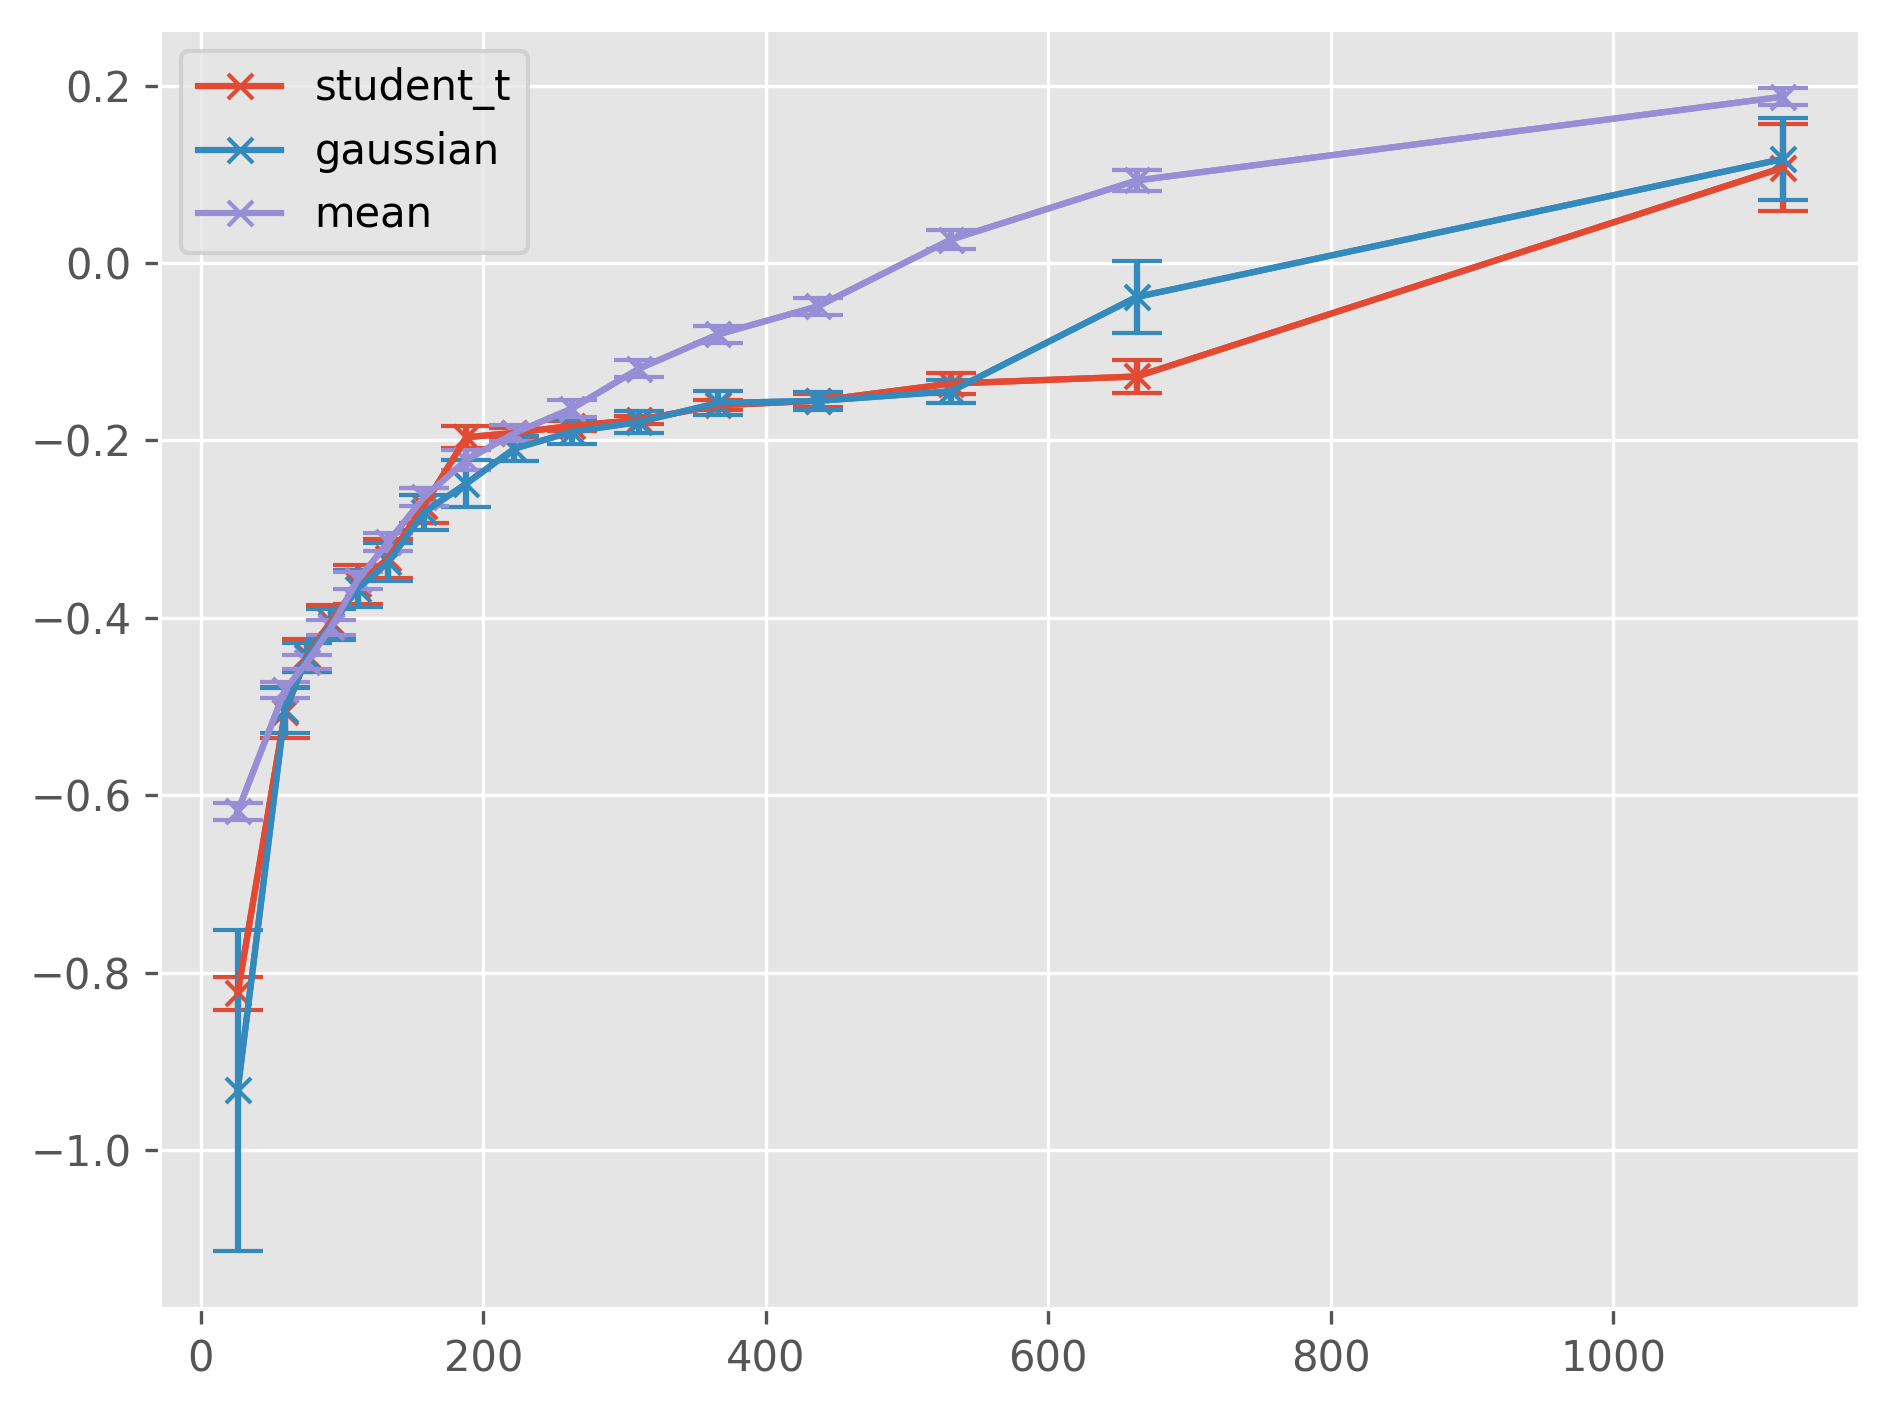

In [16]:
x = (bins[1:] + bins[:-1]) / 2

for i, cv in enumerate(central_values):
    Plots.Plot(x,   np.array(central_values[cv][0], dtype = float), marker = "x", label = cv, color = f"C{i}", newFigure = False)
    plt.errorbar(x, np.array(central_values[cv][0], dtype = float), np.array(central_values[cv][1], dtype = float), color = f"C{i}", capsize = 6)

## fractional error fit

student_t

gaussian

mean

{
    'student_t': array([ 0.11931392, 24.7660059 , -0.85050448]),
    'gaussian': array([ 0.14120379, 24.9015671 , -0.9875637 ]),
    'mean': array([  0.25890072, -20.91667231,  -1.62064135])
}

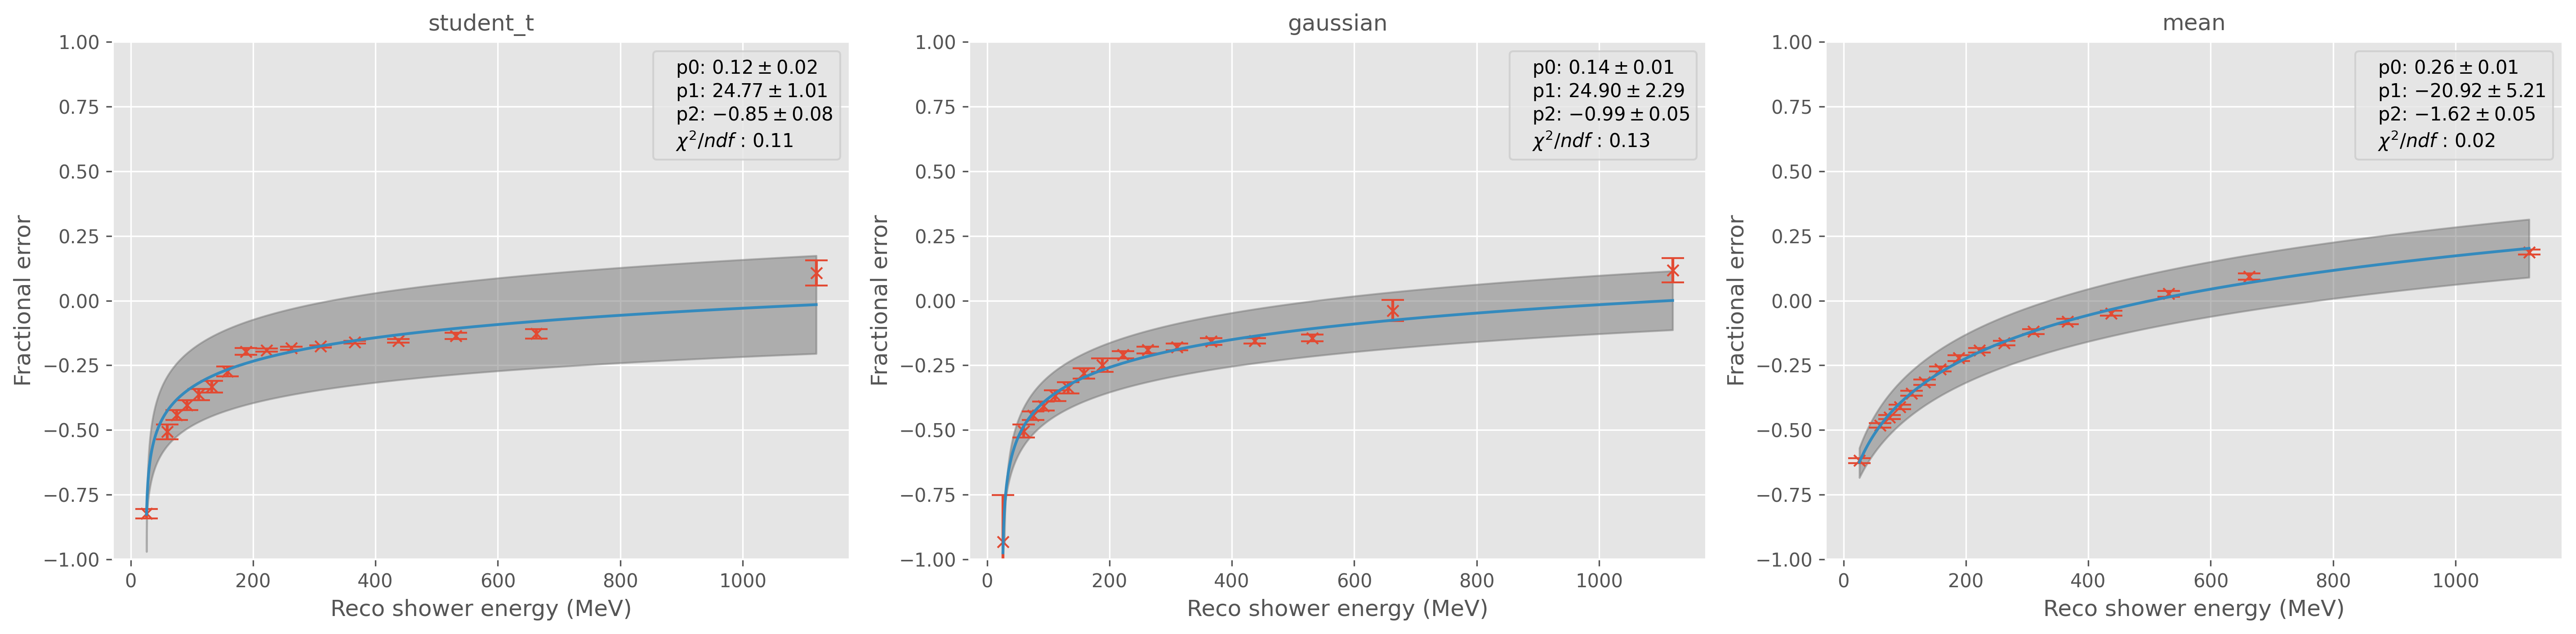

In [18]:
def fe_fit(y_obs, y_err, func):
    x = (bins[1:] + bins[:-1]) / 2
    x_interp = np.linspace(min(x), max(x), 1000)

    y_obs = np.array(y_obs, dtype = float)
    y_err = np.array(y_err, dtype = float)

    mask = ~np.isnan(np.array(y_obs, dtype = float))

    x = np.array(x[mask], dtype = float)
    y_obs = np.array(y_obs[mask], dtype = float)
    y_err = np.array(y_err[mask], dtype = float)

    popt, pcov = curve_fit(func, x, y_obs, sigma = y_err, maxfev = int(10E4))
    perr = np.sqrt(np.diag(pcov))

    y_pred = func(x, *popt)
    y_pred_min = func(x, *(popt - perr))
    y_pred_max = func(x, *(popt + perr))
    y_pred_err = (abs(y_pred - y_pred_min) + abs(y_pred - y_pred_max)) / 2

    chisqr = np.nansum(((y_obs - y_pred)/y_pred_err)**2)
    ndf = len(y_obs) - len(popt)

    Plots.Plot(x, y_obs, marker = "x", linestyle = "", color = "C0", newFigure = False)
    plt.errorbar(x, y_obs, y_err, linestyle = "", capsize = 6, color = "C0")
    Plots.Plot(x_interp, func(x_interp, *popt), newFigure = False, x_scale = "linear", xlabel = "Reco shower energy (MeV)", ylabel = "Fractional error", color = "C1")
    plt.fill_between(x_interp, func(x_interp, *(popt + perr)), func(x_interp, *(popt - perr)), color = "C3", alpha = 0.5)
    plt.ylim(-1, 1)

    text = ""
    for j in range(len(popt)):
        text += f"\np{j}: ${popt[j]:.2f}\pm${perr[j]:.2f}"
    text += "\n$\chi^{2}/ndf$ : " + f"{chisqr/ndf:.2f}"
    legend = plt.gca().legend(handlelength = 0, labels = [text[1:]])
    for l in legend.legendHandles:
        l.set_visible(False)

    return popt

response_params = {}
dims = figure_dimensions(len(central_values))
plt.subplots(dims[0], dims[1], figsize = [6.4 * dims[1], 4.8 * dims[0]])
for i, cv in enumerate(central_values):
    print(cv)
    plt.subplot(dims[0], dims[1], i + 1)
    popt = fe_fit(central_values[cv][0], central_values[cv][1], cross_section.EnergyCorrection.ResponseFit)
    plt.title(cv)
    response_params[cv] = popt

print(response_params)
if save: Plots.Save("respone_fits", path)

# Linear vs response fit

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


uncorrected : mean -0.162 std 0.472

linear : mean 0.010 std 0.569

student_t : mean 0.080 std 0.523

gaussian : mean 0.127 std 0.910

mean : mean 0.040 std 0.485

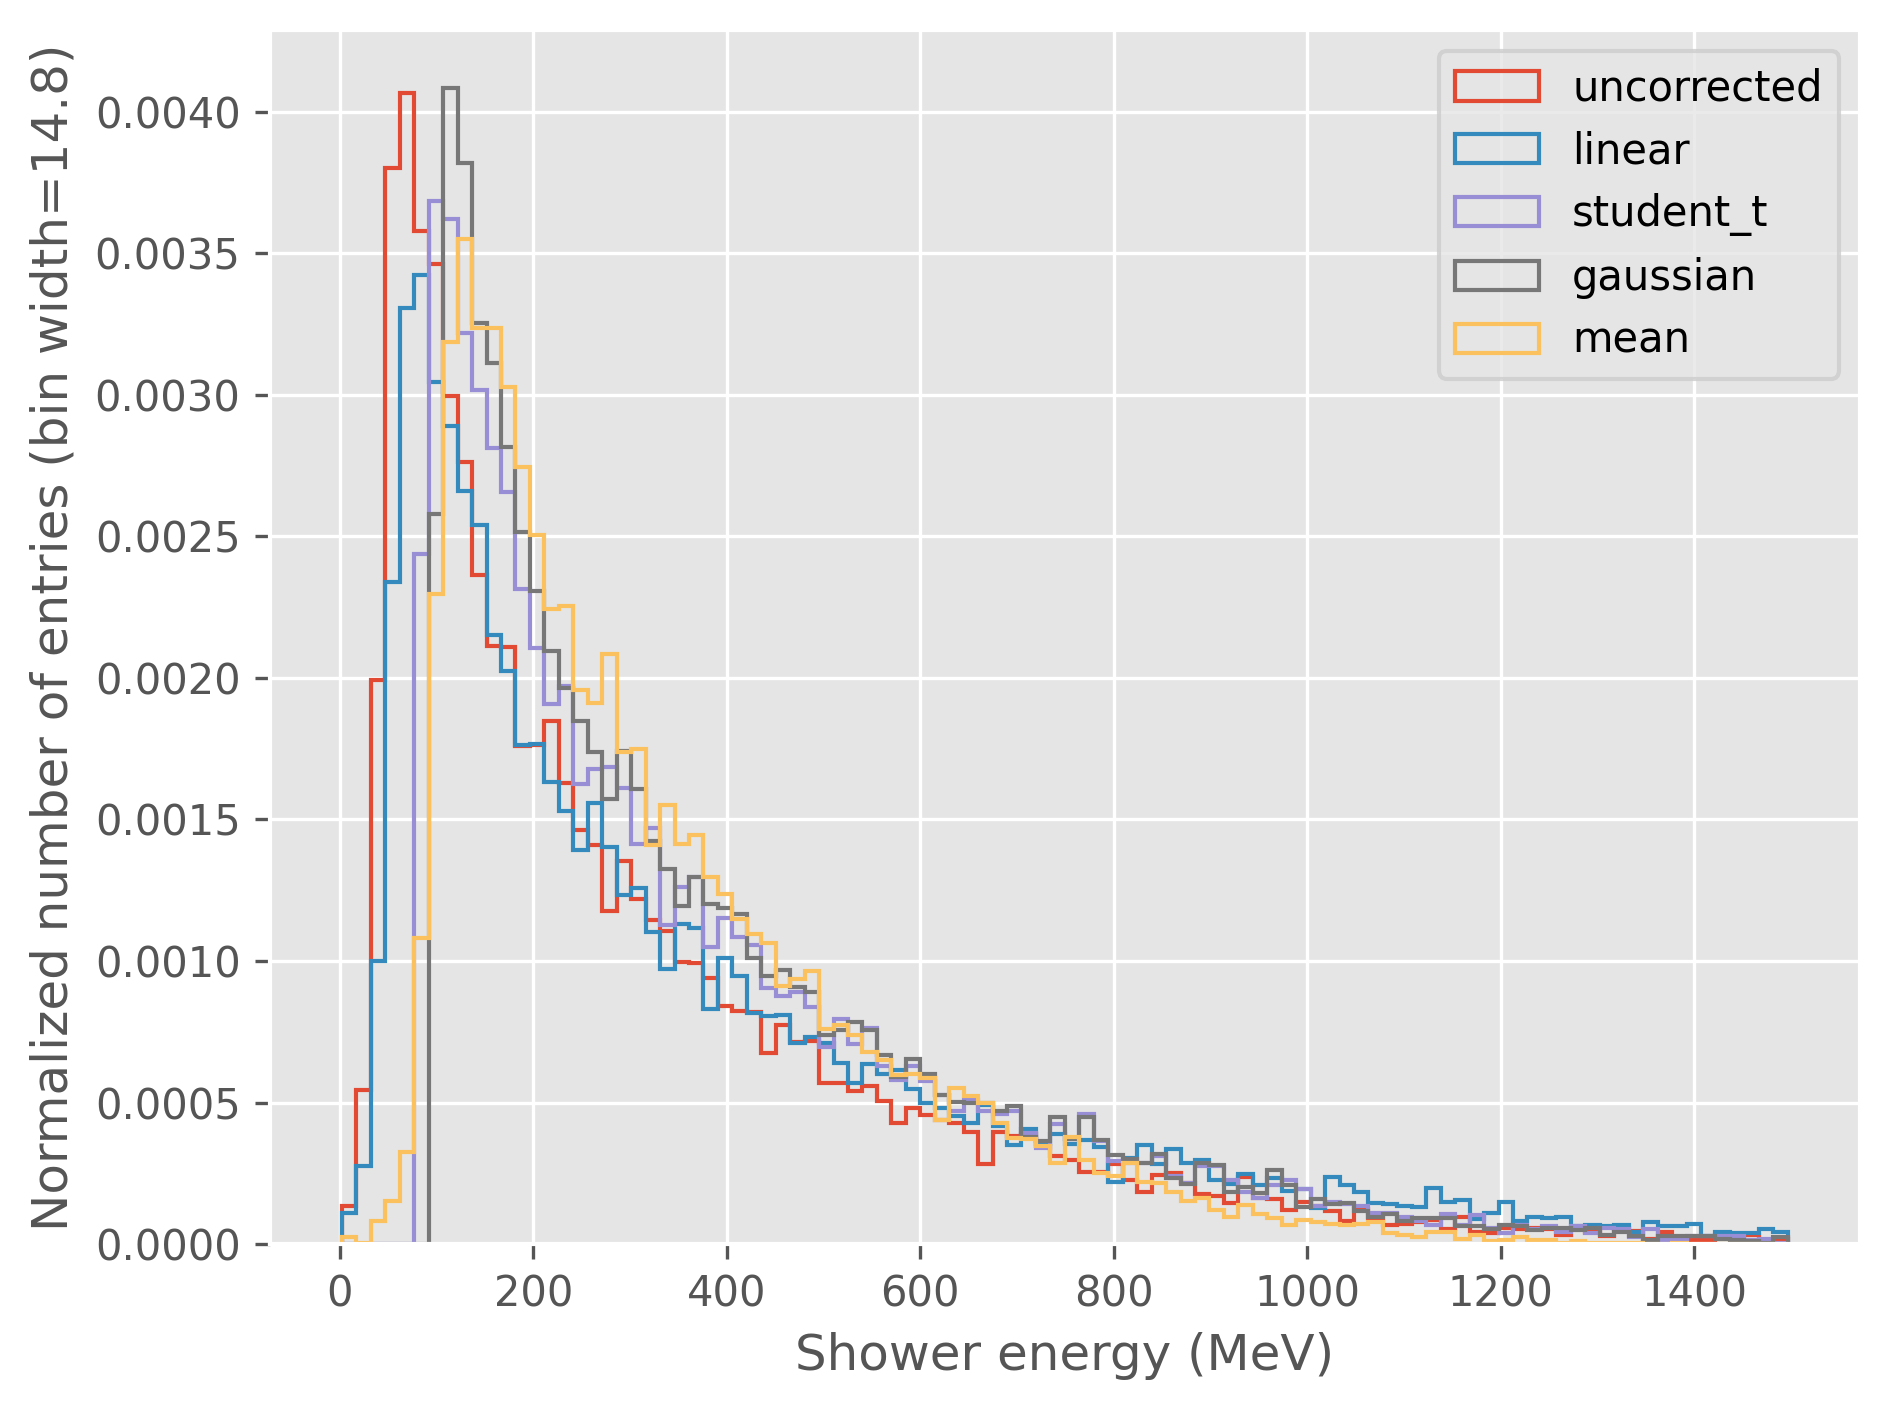

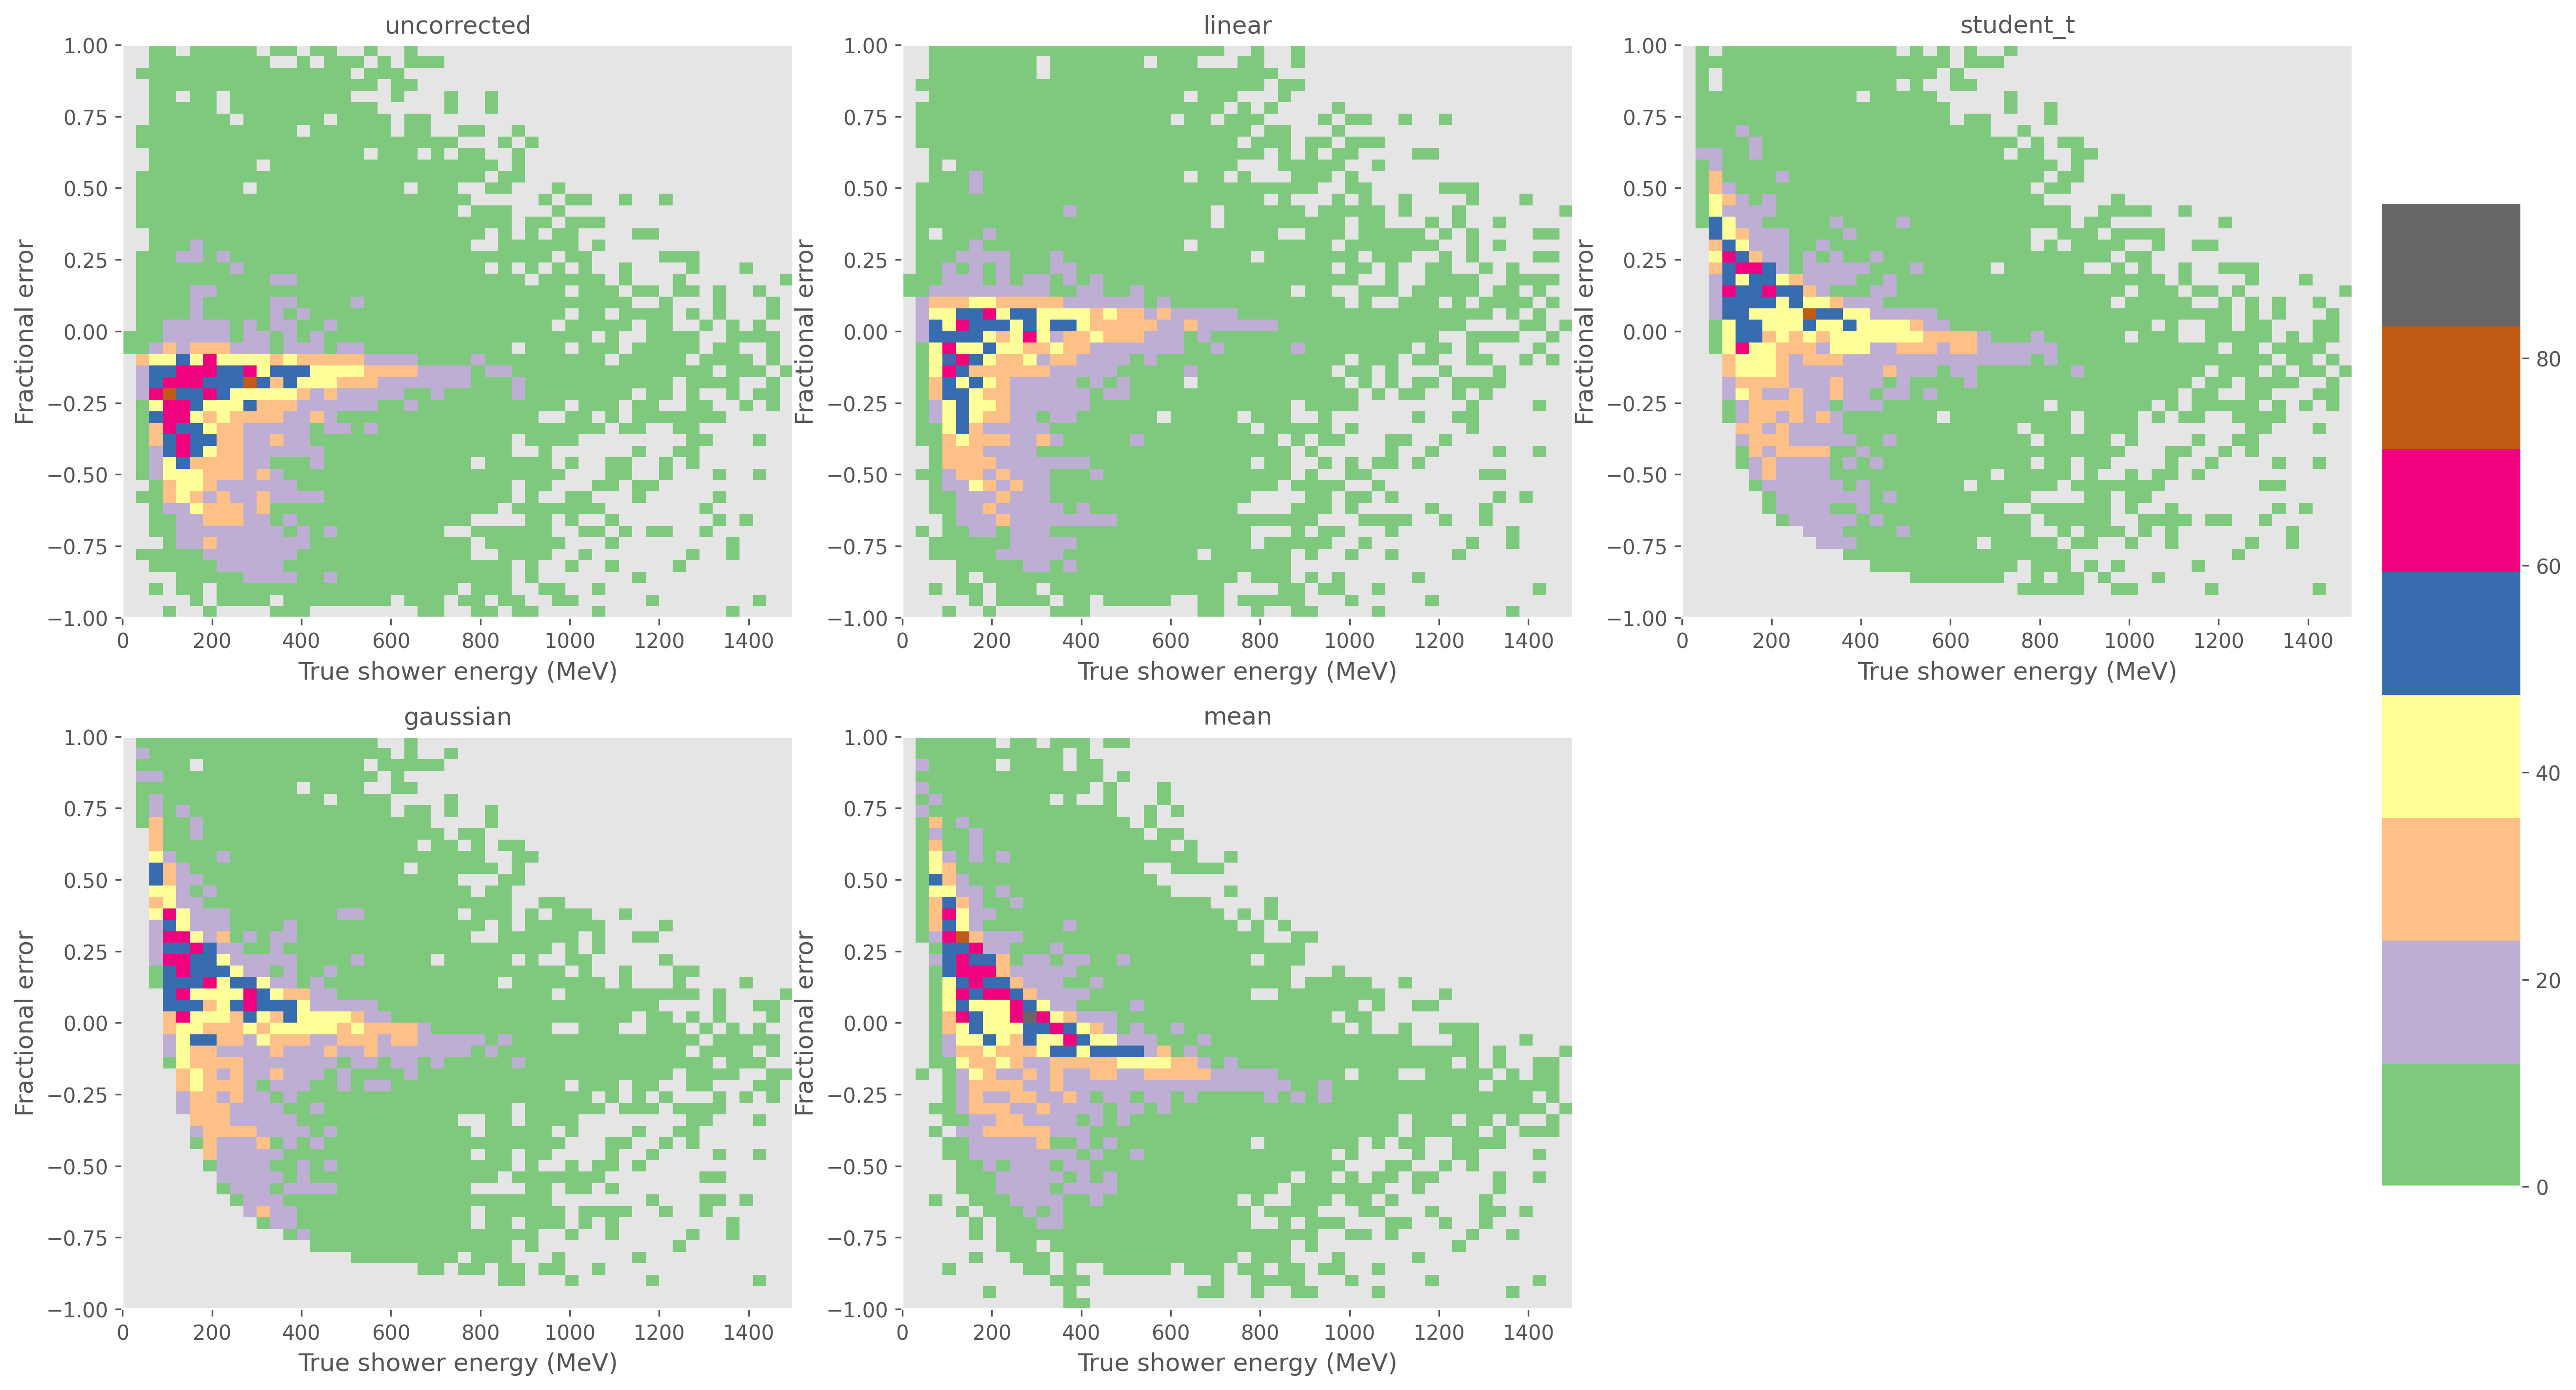

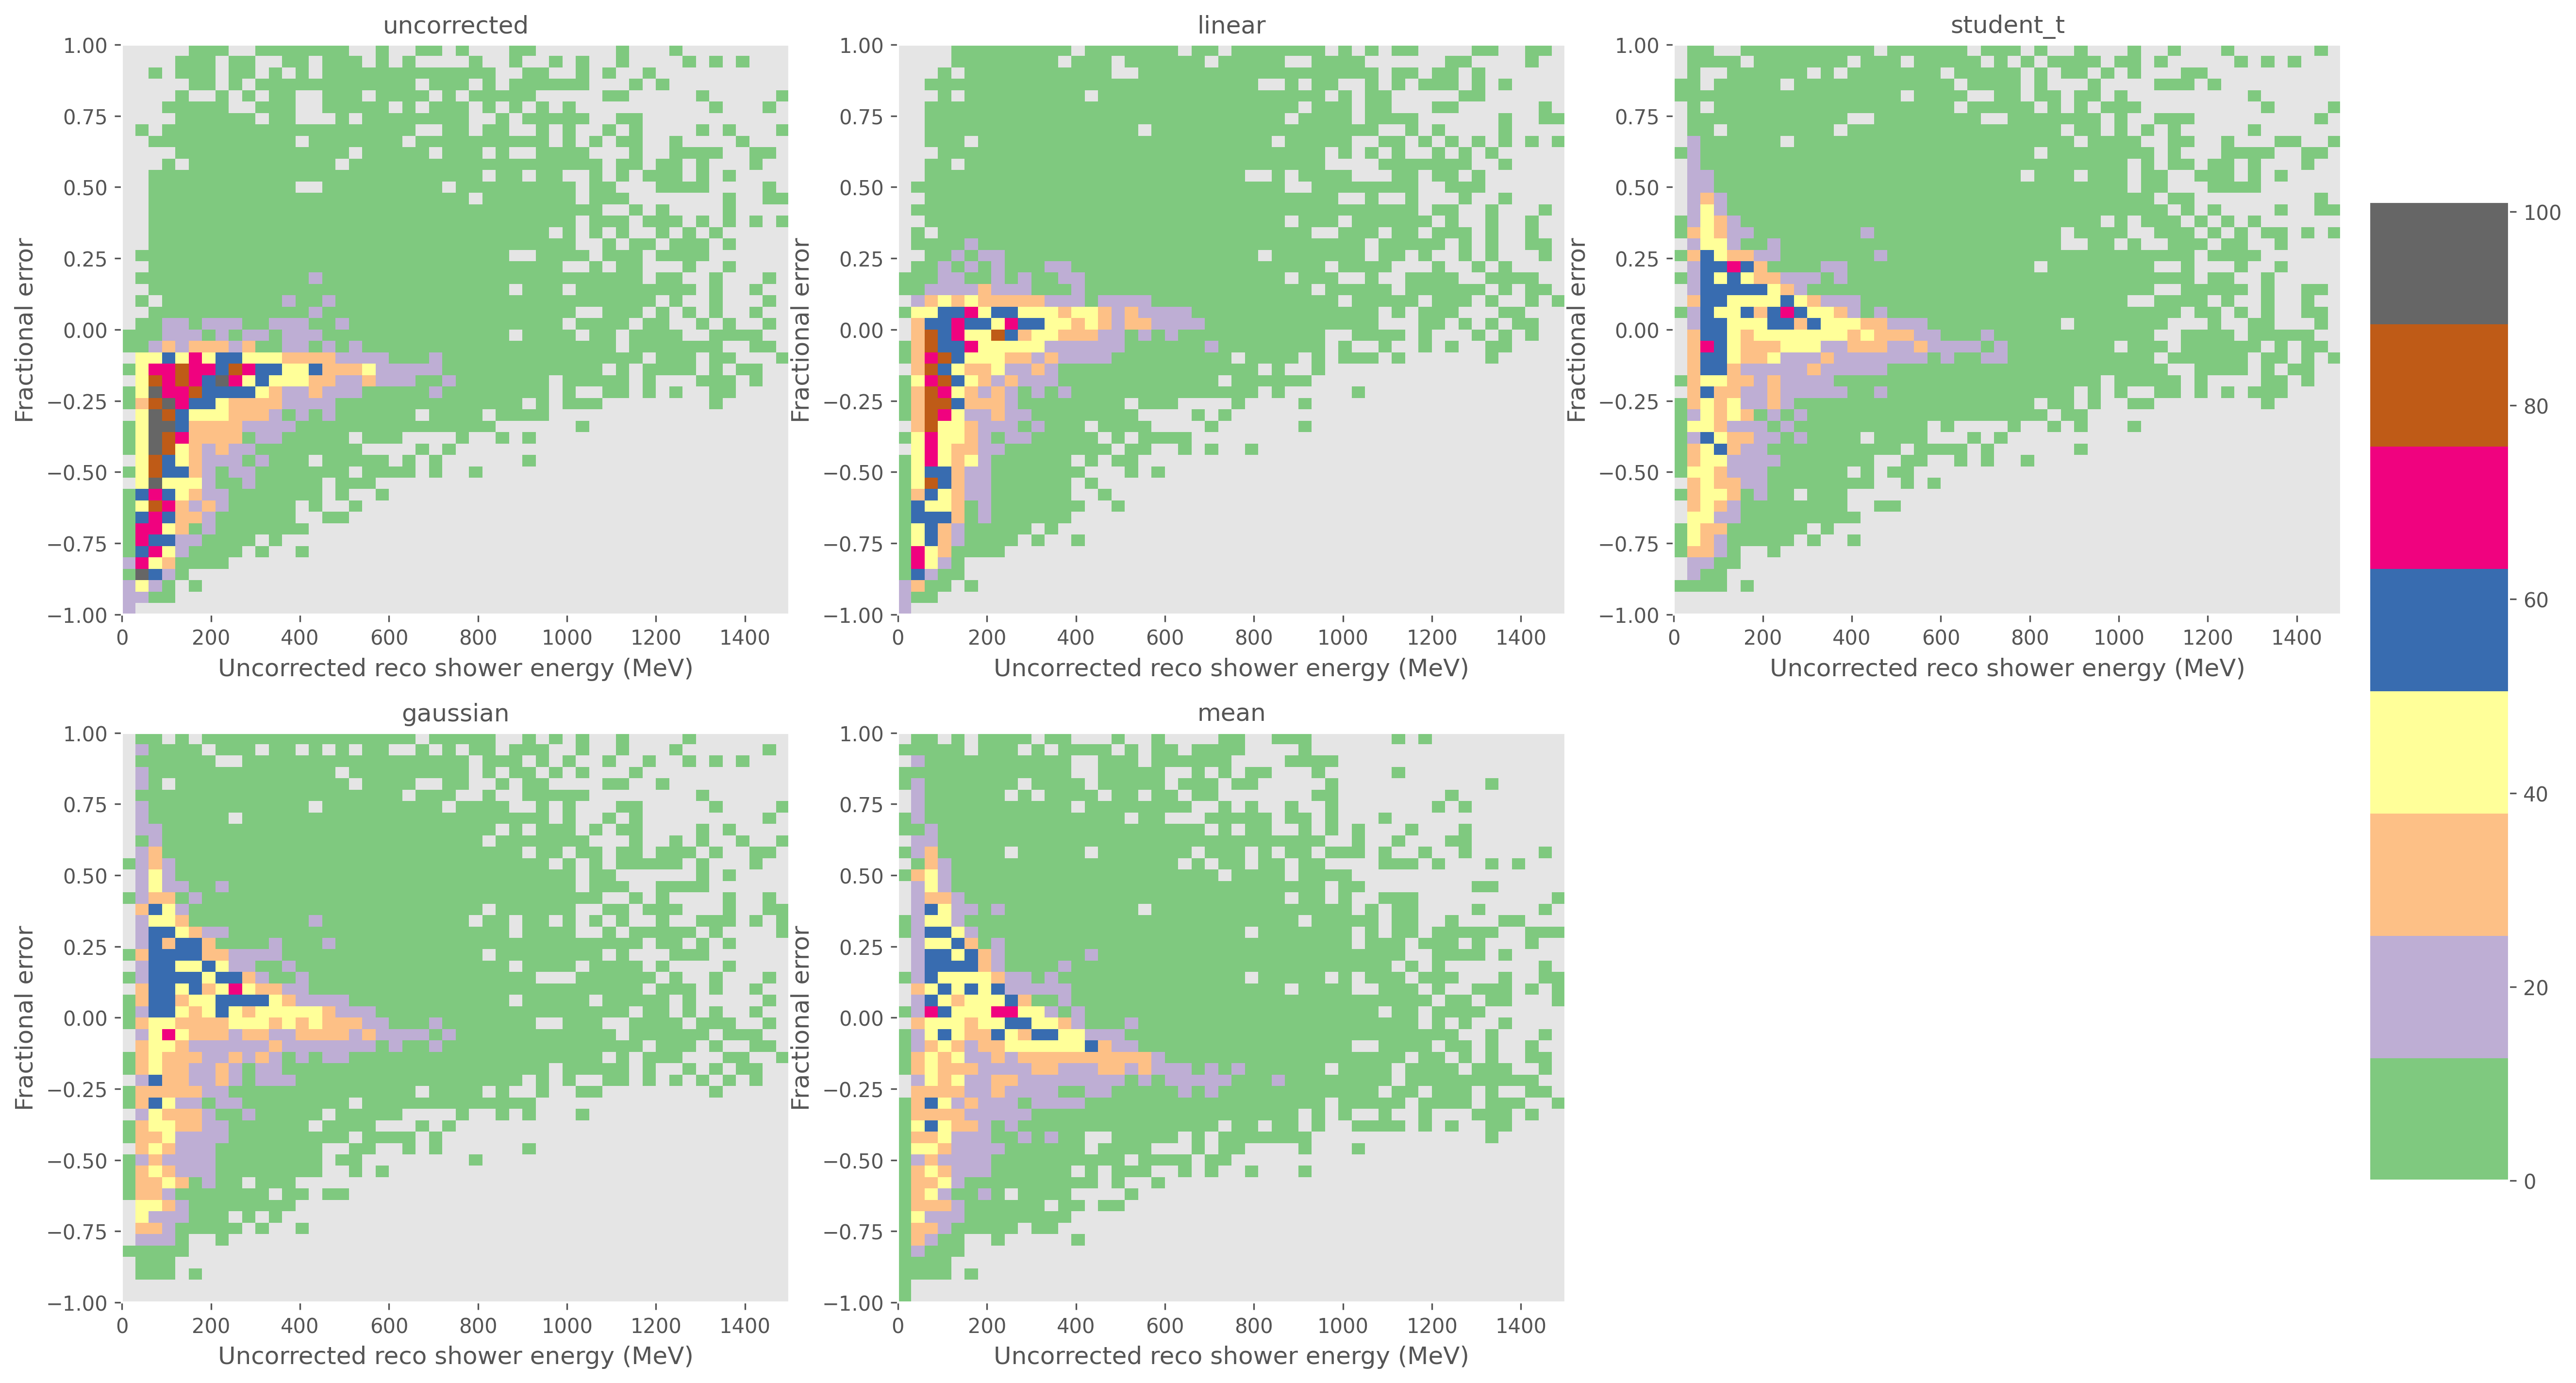

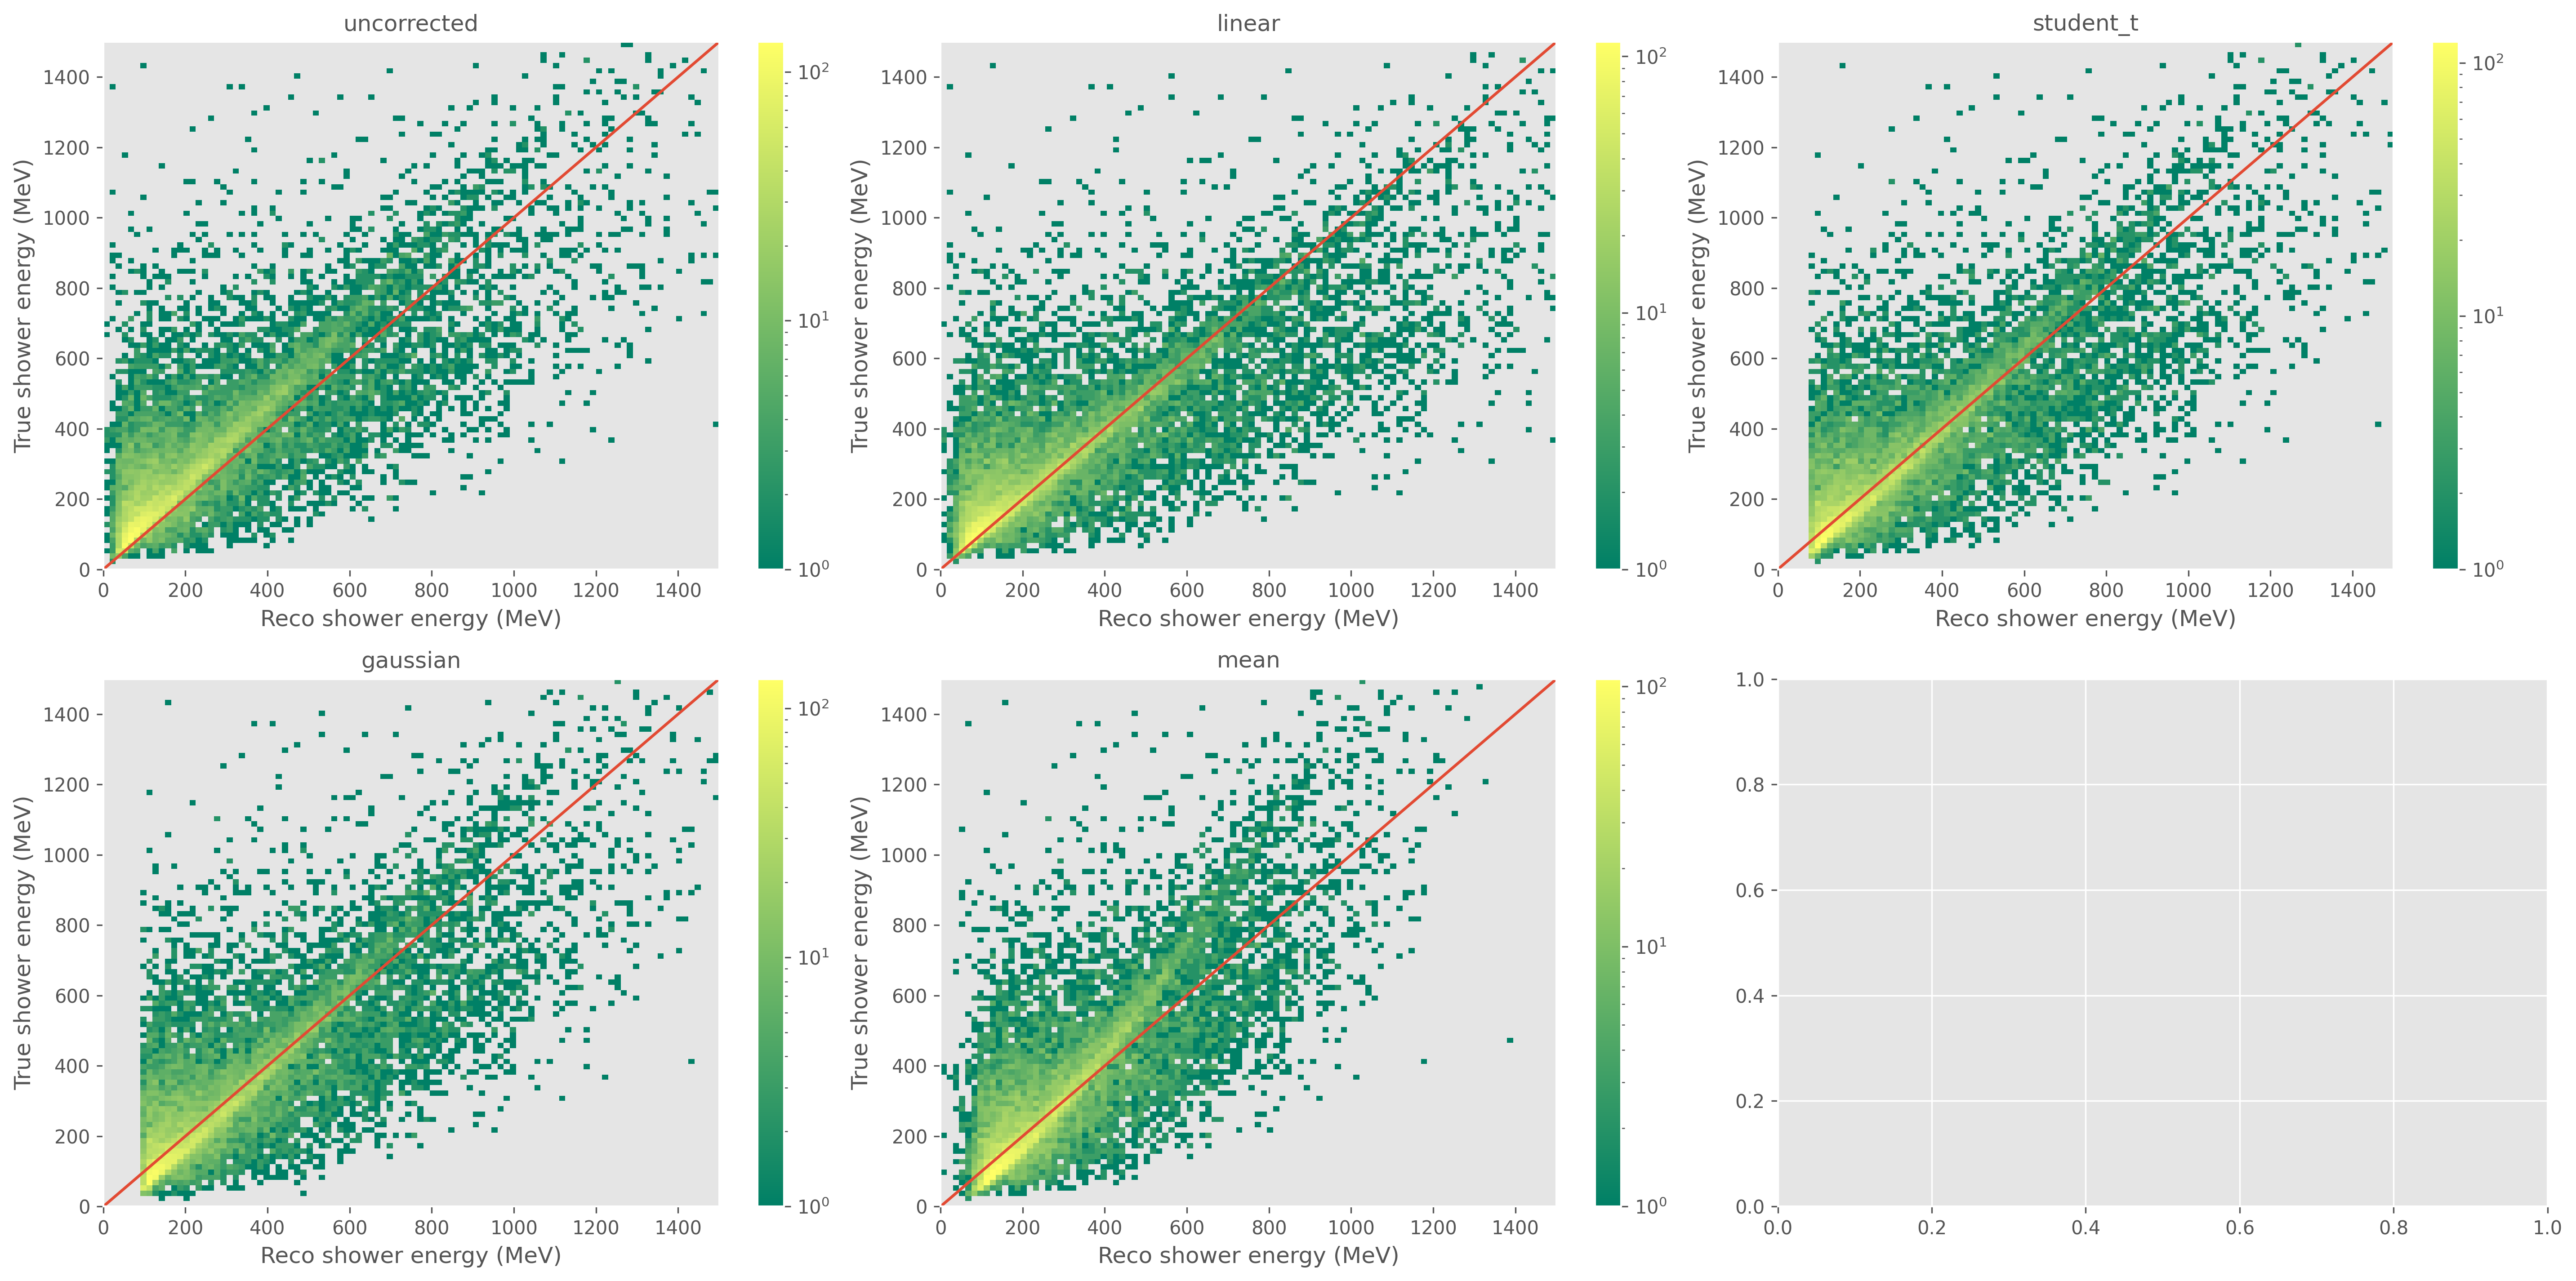

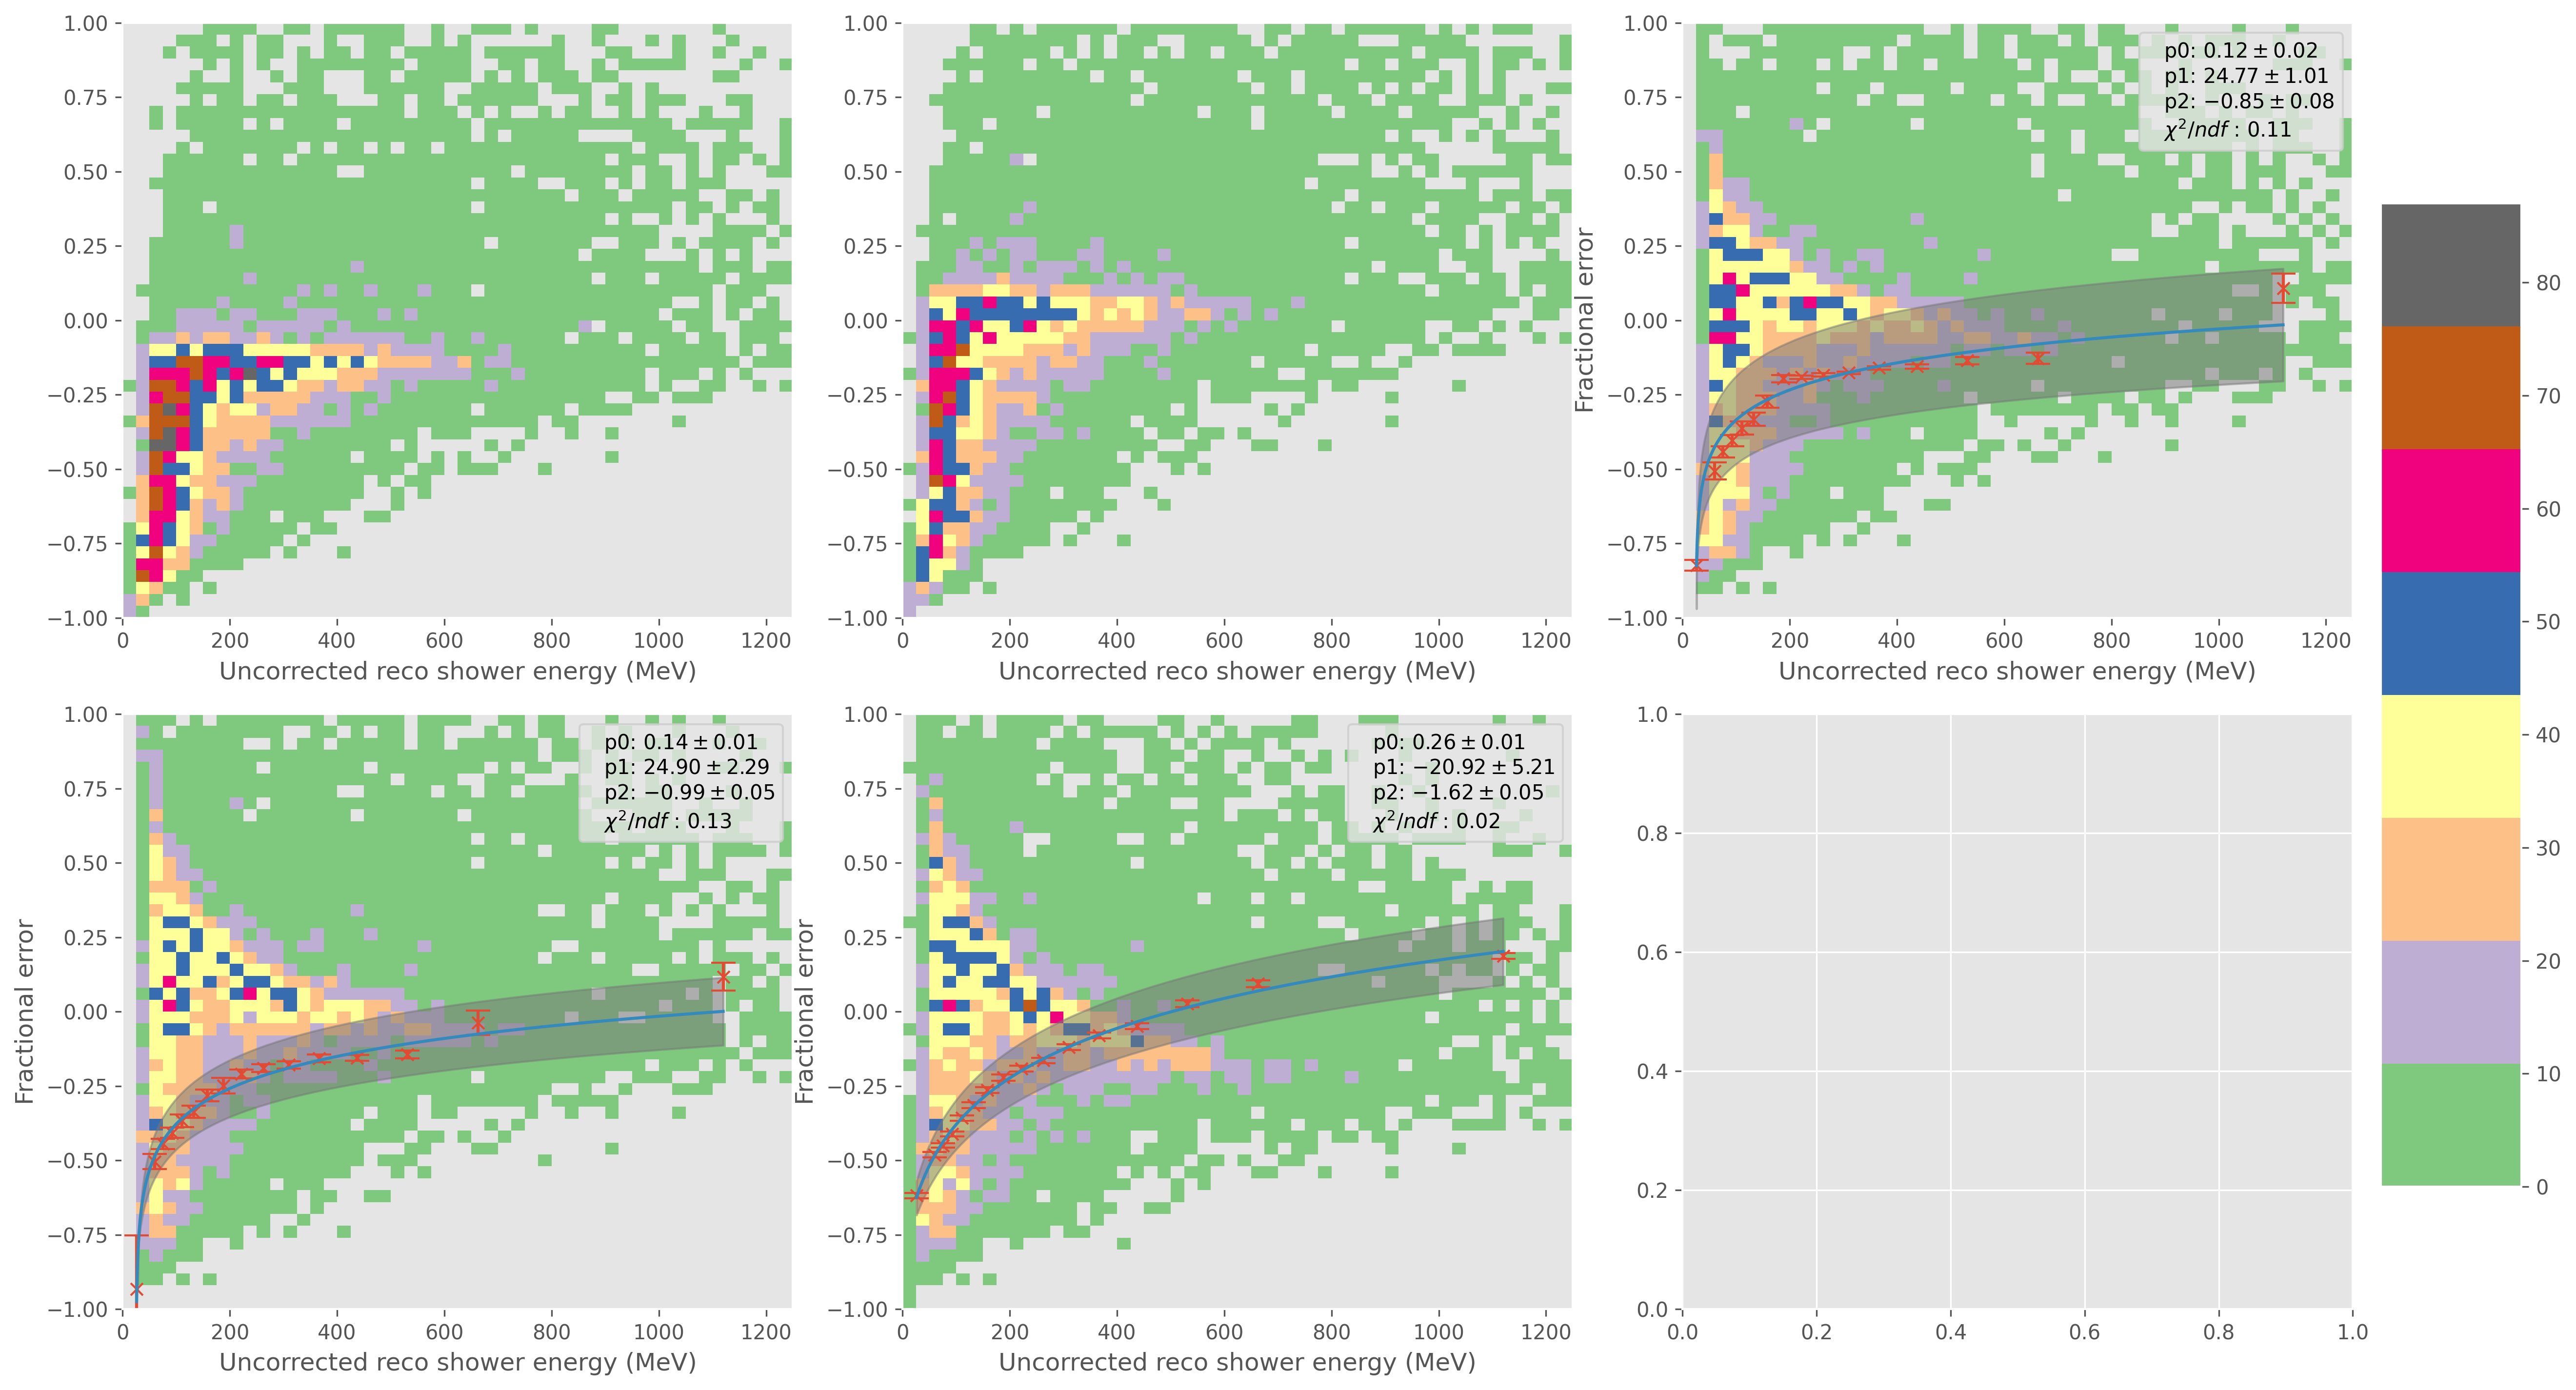

In [19]:
energies = {"uncorrected" : df.reco_energy, "linear" : df.reco_energy / linear_correction}

for p in response_params:
    energies[p] = cross_section.EnergyCorrection.ResponseCorrection(df.reco_energy, *response_params[p])

Plots.PlotHistComparison(list(energies.values()), labels = list(energies.keys()), xRange = energy_range, xlabel = "Shower energy (MeV)")

fe = {i : (energies[i]/df.true_energy) - 1 for i in energies}

Hist2DComparison([df.true_energy]*len(fe), list(fe.values()), energy_range, [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*len(fe), y_labels = ["Fractional error"]*len(fe), titles = list(fe.keys()))
if save is True: Plots.Save("fraction_error_all", path)

Hist2DComparison([df.reco_energy]*len(fe), list(fe.values()), energy_range, [-1, 1], bins = 50, cmap = "Accent", x_labels = ["Uncorrected reco shower energy (MeV)"]*len(fe), y_labels = ["Fractional error"]*len(fe), titles = list(fe.keys()))
if save is True: Plots.Save("fraction_error_reco_all", path)

dim = figure_dimensions(len(fe))

plt.subplots(dim[0], dim[1], figsize = [6.4 * dim[1], 4.8 * dim[0]])
for i, (l, e) in enumerate(energies.items()):
    plt.subplot(dim[0], dim[1], i + 1)
    Plots.PlotHist2D(e, df.true_energy, bins = 100, title = l, xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)", x_range = energy_range, y_range = energy_range, cmap = "summer", newFigure = False)
    plt.plot(energy_range, energy_range)
if save is True: Plots.Save("truth_reco_all", path)

for l, f in fe.items():
    print(f"{l} : mean {f.mean():.3f} std {f.std():.3f}")

def FractionalErrorOverlay():
    dim = figure_dimensions(len(fe))
    fig, _ = plt.subplots(dim[0], dim[1], figsize = [6.4 * dim[1], 4.8 * dim[0]])

    ranges = [[0, 1250], [-1, 1]]

    vmax = 0
    for xs, ys in zip([energies["uncorrected"]], fe.values()):
        h, _, _ = np.histogram2d(xs, ys, 50, range = ranges)
        vmax = max(vmax, np.max(h))

    for i, (l, e) in enumerate(fe.items()):
        plt.subplot(*dim, i + 1)

        _, _, _, im = plt.hist2d(energies["uncorrected"], e, 50, range = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = "Accent")

        if l in central_values:
            fe_fit(central_values[l][0], central_values[l][1], cross_section.EnergyCorrection.ResponseFit)
        plt.xlabel("Uncorrected reco shower energy (MeV)")

    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.subplots_adjust(right=0.84)
    fig.colorbar(im, cax = cbar_ax)

FractionalErrorOverlay()

In [20]:
from particle import Particle
from python.analysis import Master
pairs = pd.read_hdf("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5", "photon_pairs")
tags = pd.read_hdf("work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5", "tags")

mass = {"uncorrected" : Master.ShowerPairs.Mass(pairs.shower_pairs_reco_lead_energy, pairs.shower_pairs_reco_sub_energy, pairs.shower_pairs_reco_angle)}
mass["linear"] = Master.ShowerPairs.Mass(
    cross_section.EnergyCorrection.LinearCorrection(pairs.shower_pairs_reco_lead_energy, linear_correction), 
    cross_section.EnergyCorrection.LinearCorrection(pairs.shower_pairs_reco_sub_energy, linear_correction), 
    pairs.shower_pairs_reco_angle
    )

for p in response_params:
    mass[p] = Master.ShowerPairs.Mass(
        cross_section.EnergyCorrection.ResponseCorrection(pairs.shower_pairs_reco_lead_energy, *response_params[p]),
        cross_section.EnergyCorrection.ResponseCorrection(pairs.shower_pairs_reco_sub_energy,  *response_params[p]),
        pairs.shower_pairs_reco_angle
        )

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones


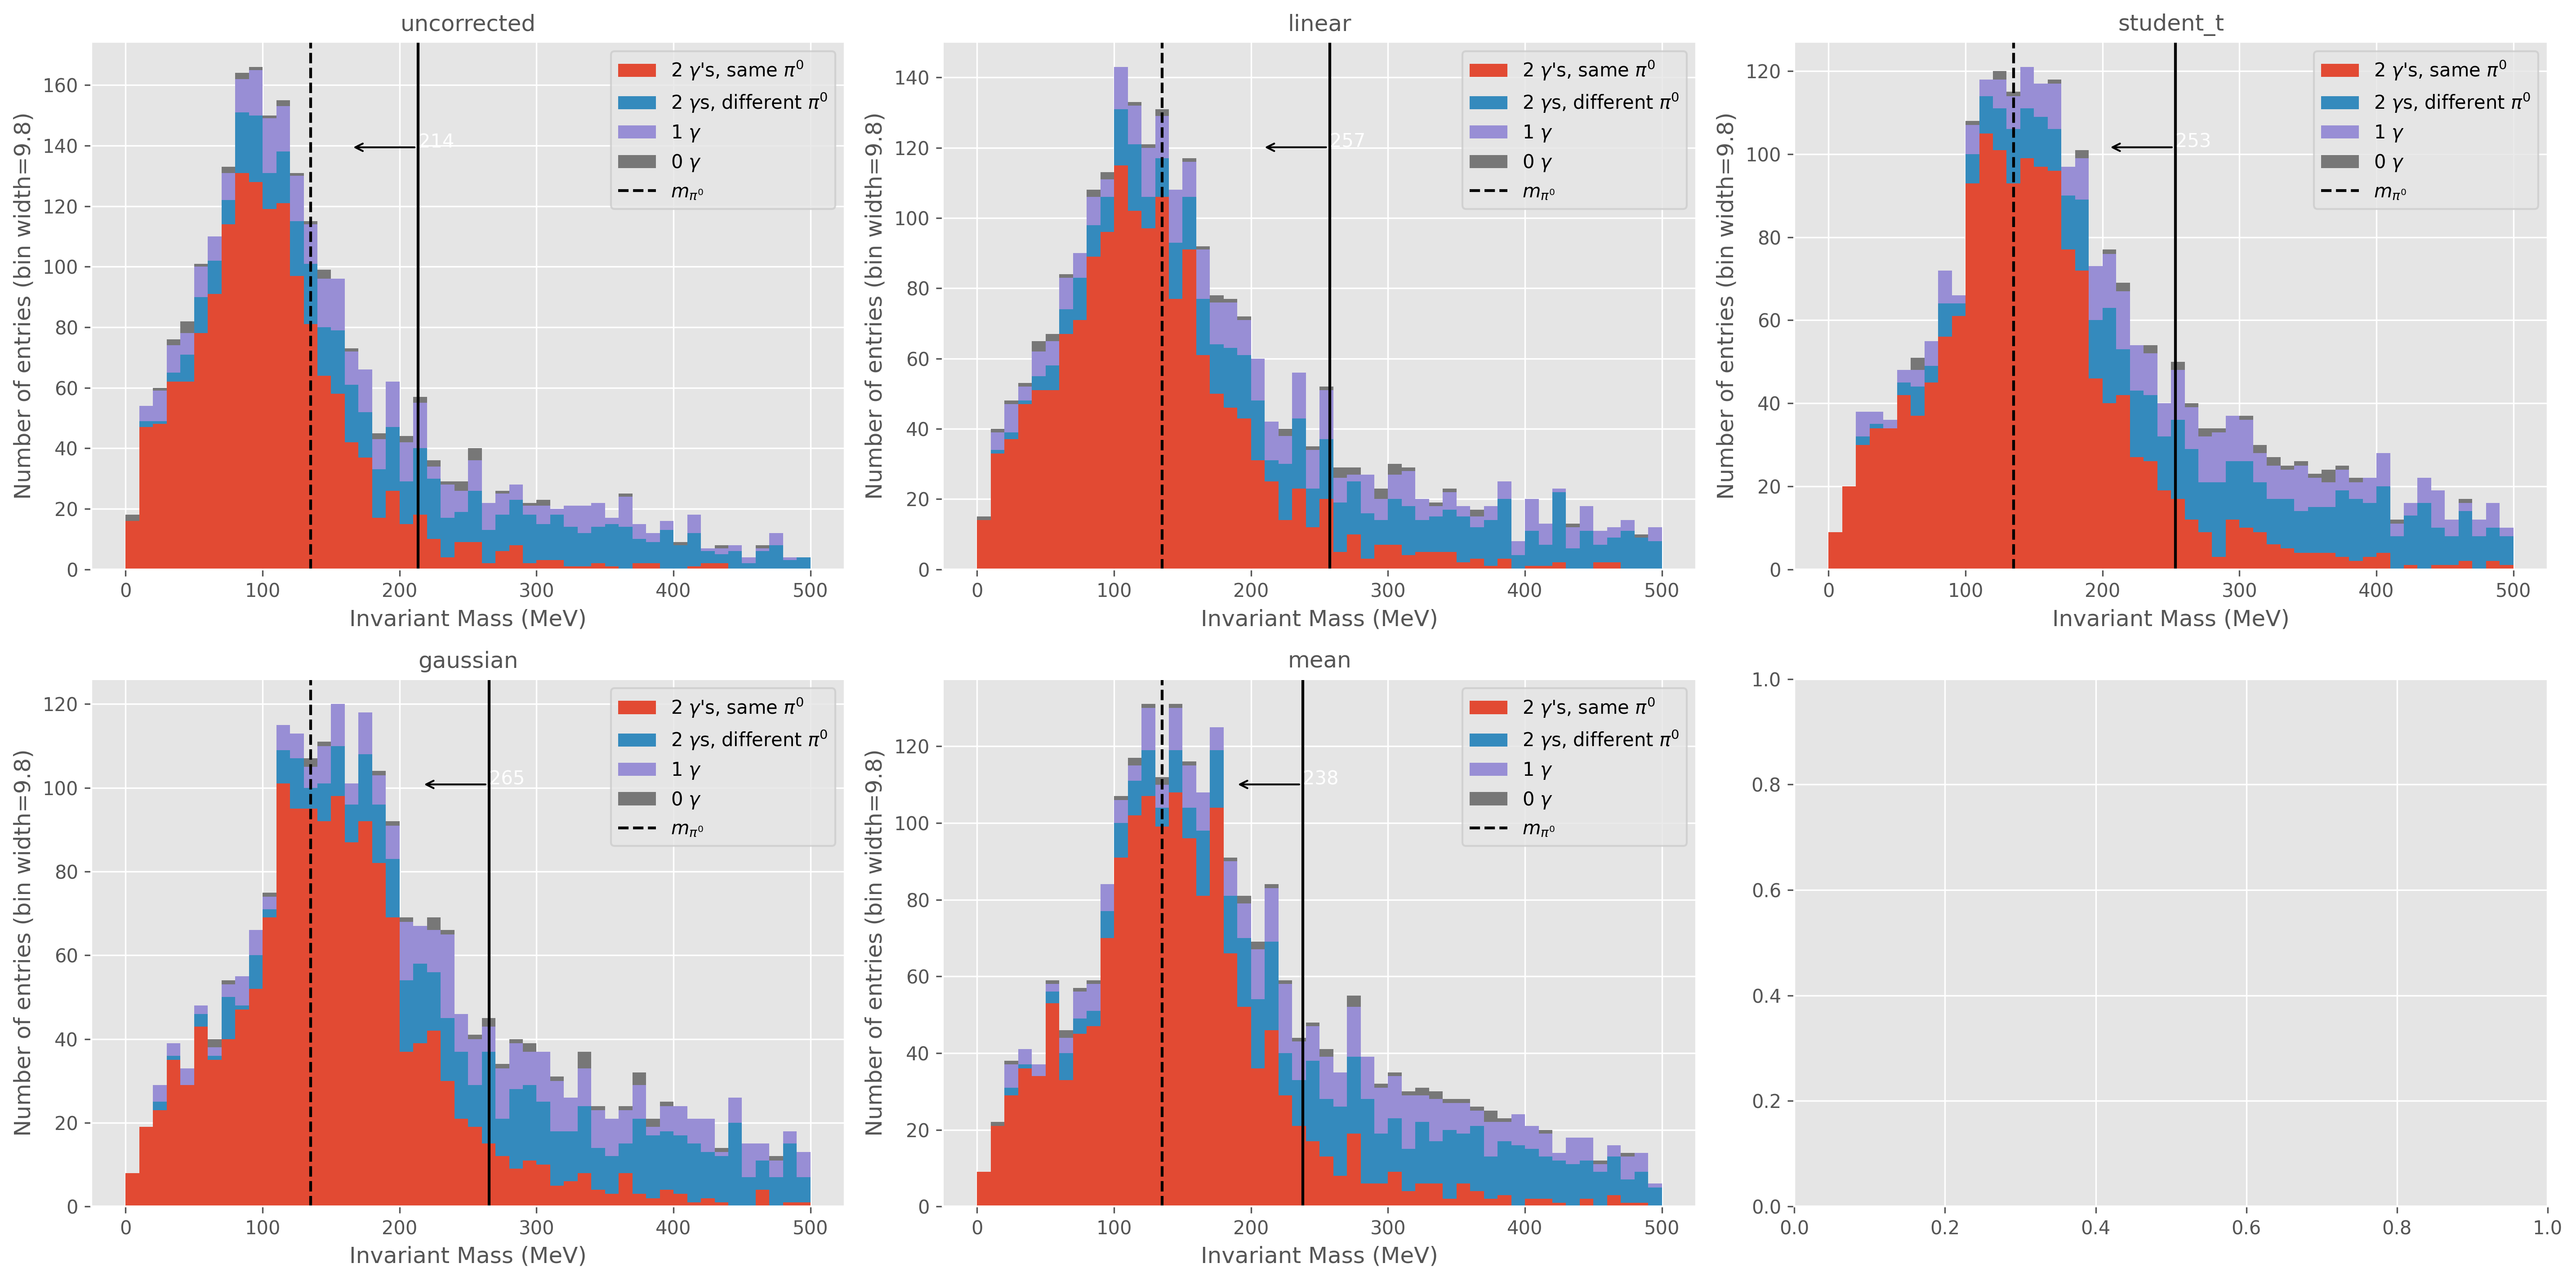

In [21]:
from python.analysis import Tags

def cut_scan(value : np.array, signal_mask : np.array, nsamples : int = 100):
    cuts = np.nanpercentile(value, np.linspace(1, 99, nsamples))

    s_e = []
    s_p = []
    s_y = []
    b_y = []
    for c in cuts:
        mask = value < c
        s_e.append(np.sum(signal_mask[mask]) / len(signal_mask))
        s_p.append(np.sum(signal_mask[mask]) / len(signal_mask[mask]))
        s_y.append(np.sum(signal_mask[mask]))
        b_y.append(np.sum(~signal_mask[mask]))
        
    s_e = np.array(s_e)
    s_p = np.array(s_p)
    s_y = np.array(s_y)
    b_y = np.array(b_y)
    return s_e, s_p, s_y, b_y, cuts

def optimal_cut(value : np.array, signal_mask : np.array, visualise : bool = False):

    s_e, s_p, _, _, cuts = cut_scan(value, signal_mask)
    score = s_e * s_p

    best = np.nanargmax(score)
    optimal = cuts[best]

    if visualise:
        Plots.Plot(cuts, s_e, label = "efficiency", newFigure = False)
        Plots.Plot(cuts, s_p, newFigure = False, label = "purity")
        Plots.Plot(cuts, score, newFigure = False, label = "purity $\\times$ efficiency")
        plt.axvline(optimal, linestyle = "--", color = "black", label = f"optimal cut: {optimal:.0f}")
        plt.xlabel("value")
        plt.legend()
        plt.ylim(0, 1)
    return optimal, s_p[best], s_e[best]

def mass_tag_plots(tags : Tags.Tags):
    dims = figure_dimensions(len(mass))
    plt.subplots(dims[0], dims[1], figsize = [6.4 * dims[1], 4.8 * dims[0]])
    for i, (l, m) in enumerate(mass.items()):
        plt.subplot(dims[0], dims[1], i + 1)
        Plots.PlotTagged(m, tags, title = l, x_range = [0, 500], bins = 50, newFigure = False, x_label = "Invariant Mass (MeV)")

        cut_position, purity, efficiency = optimal_cut(m, tags.number[0].mask)

        Plots.DrawCutPosition(cut_position, arrow_length = 50, face = "left", annotate = True)
        plt.axvline(Particle.from_pdgid(111).mass, color = "black", linestyle = "--", label = "$m_{\pi^{0}}$")
        plt.legend()

pi0_tags = Tags.Tags()
for i in range(4):
    pi0_tags[tags.pi0_tags[i].name] = tags.pi0_tags[i]

# fs_tags = Tags.Tags()
# for i in range(4, len(tags)):
#     fs_tags[tags.final_state_tags[i].name] = tags.final_state_tags[i]

# reordered_fs_tags = Tags.Tags()

# reordered_fs_tags['$1\\pi^{0} + 0\\pi^{+}$'] = fs_tags['$1\\pi^{0} + 0\\pi^{+}$']
# reordered_fs_tags['$1\\pi^{0} + \\geq 1\\pi^{+}$'] = fs_tags['$1\\pi^{0} + \\geq 1\\pi^{+}$']
# reordered_fs_tags['$> 1\\pi^{0} + \\geq 0\\pi^{+}$'] = fs_tags['$> 1\\pi^{0} + \\geq 0\\pi^{+}$']
# reordered_fs_tags['$0\\pi^{0} + \\geq 1\\pi^{+}$'] = fs_tags['$0\\pi^{0} + \\geq 1\\pi^{+}$']
# reordered_fs_tags['$0\\pi^{0} + 0\\pi^{+}$'] = fs_tags['$0\\pi^{0} + 0\\pi^{+}$']
# fs_tags = reordered_fs_tags

mass_tag_plots(pi0_tags)
if save is True: Plots.Save("inv_mass_pi0", path)

# mass_tag_plots(fs_tags)
# if save is True: Plots.Save("inv_mass_fs", path)


In [80]:
counts = {}
purities = {}
efficiencies = {}
for m in mass:
    print(m)
    cut_position, _, _ = optimal_cut(mass[m], pi0_tags.number[0].mask)
    mask = mass[m] < cut_position

    c = {}
    p = {}
    e = {}
    for t in pi0_tags:
        c[t] = np.sum(pi0_tags[t].mask[mask])
        e[t] = np.sum(pi0_tags[t].mask[mask])/np.sum(pi0_tags[t].mask)
        p[t] = np.sum(pi0_tags[t].mask[mask])/len(pi0_tags[t].mask[mask])
    purities[m] = p
    counts[m] = c
    efficiencies[m] = e

no_cut_counts = {t : np.sum(pi0_tags[t].mask) for t in pi0_tags}
no_cut_purity = {t : np.sum(pi0_tags[t].mask)/len(pi0_tags[t].mask) for t in pi0_tags}

counts = pd.DataFrame(counts)
counts["before cut"] = no_cut_counts
counts.loc["total"] = counts.sum(axis = "rows")
efficiencies = pd.DataFrame(efficiencies)
efficiencies.loc["total"] = efficiencies.sum(axis = "rows")

purities = pd.DataFrame(purities)
purities["before cut"] = no_cut_purity
purities.loc["total"] = purities.sum(axis = "rows")

if save:
    counts.to_latex(path + "mass_perf_counts.tex")
    purities.to_latex(path + "mass_perf_purity.tex")
    efficiencies.to_latex(path + "mass_perf_efficiency.tex")

print(counts)
print(purities)
print(efficiencies)


uncorrected

linear

student_t

gaussian

mean

uncorrected  linear  student_t  gaussian  \
2 $\gamma$'s, same $\pi^{0}$             1464    1464       1407      1410   
2 $\gamma$s, different $\pi^{0}$          286     286        229       227   
1 $\gamma$                                245     245        178       178   
0 $\gamma$                                 28      28         16        15   
total                                    2023    2023       1830      1830   

                                  mean  before cut  
2 $\gamma$'s, same $\pi^{0}$      1408        1555  
2 $\gamma$s, different $\pi^{0}$   209         636  
1 $\gamma$                         174         413  
0 $\gamma$                          22          52  
total                             1813        2656

uncorrected    linear  student_t  gaussian  \
2 $\gamma$'s, same $\pi^{0}$         0.723678  0.723678   0.768852  0.770492   
2 $\gamma$s, different $\pi^{0}$     0.141374  0.141374   0.125137  0.124044   
1 $\gamma$                           0.121107  0.121107   0.097268  0.097268   
0 $\gamma$                           0.013841  0.013841   0.008743  0.008197   
total                                1.000000  1.000000   1.000000  1.000000   

                                      mean  before cut  
2 $\gamma$'s, same $\pi^{0}$      0.776613    0.585467  
2 $\gamma$s, different $\pi^{0}$  0.115279    0.239458  
1 $\gamma$                        0.095974    0.155497  
0 $\gamma$                        0.012135    0.019578  
total                             1.000000    1.000000

uncorrected    linear  student_t  gaussian  \
2 $\gamma$'s, same $\pi^{0}$         0.941479  0.941479   0.904823  0.906752   
2 $\gamma$s, different $\pi^{0}$     0.449686  0.449686   0.360063  0.356918   
1 $\gamma$                           0.593220  0.593220   0.430993  0.430993   
0 $\gamma$                           0.538462  0.538462   0.307692  0.288462   
total                                2.522847  2.522847   2.003571  1.983125   

                                      mean  
2 $\gamma$'s, same $\pi^{0}$      0.905466  
2 $\gamma$s, different $\pi^{0}$  0.328616  
1 $\gamma$                        0.421308  
0 $\gamma$                        0.423077  
total                             2.078467

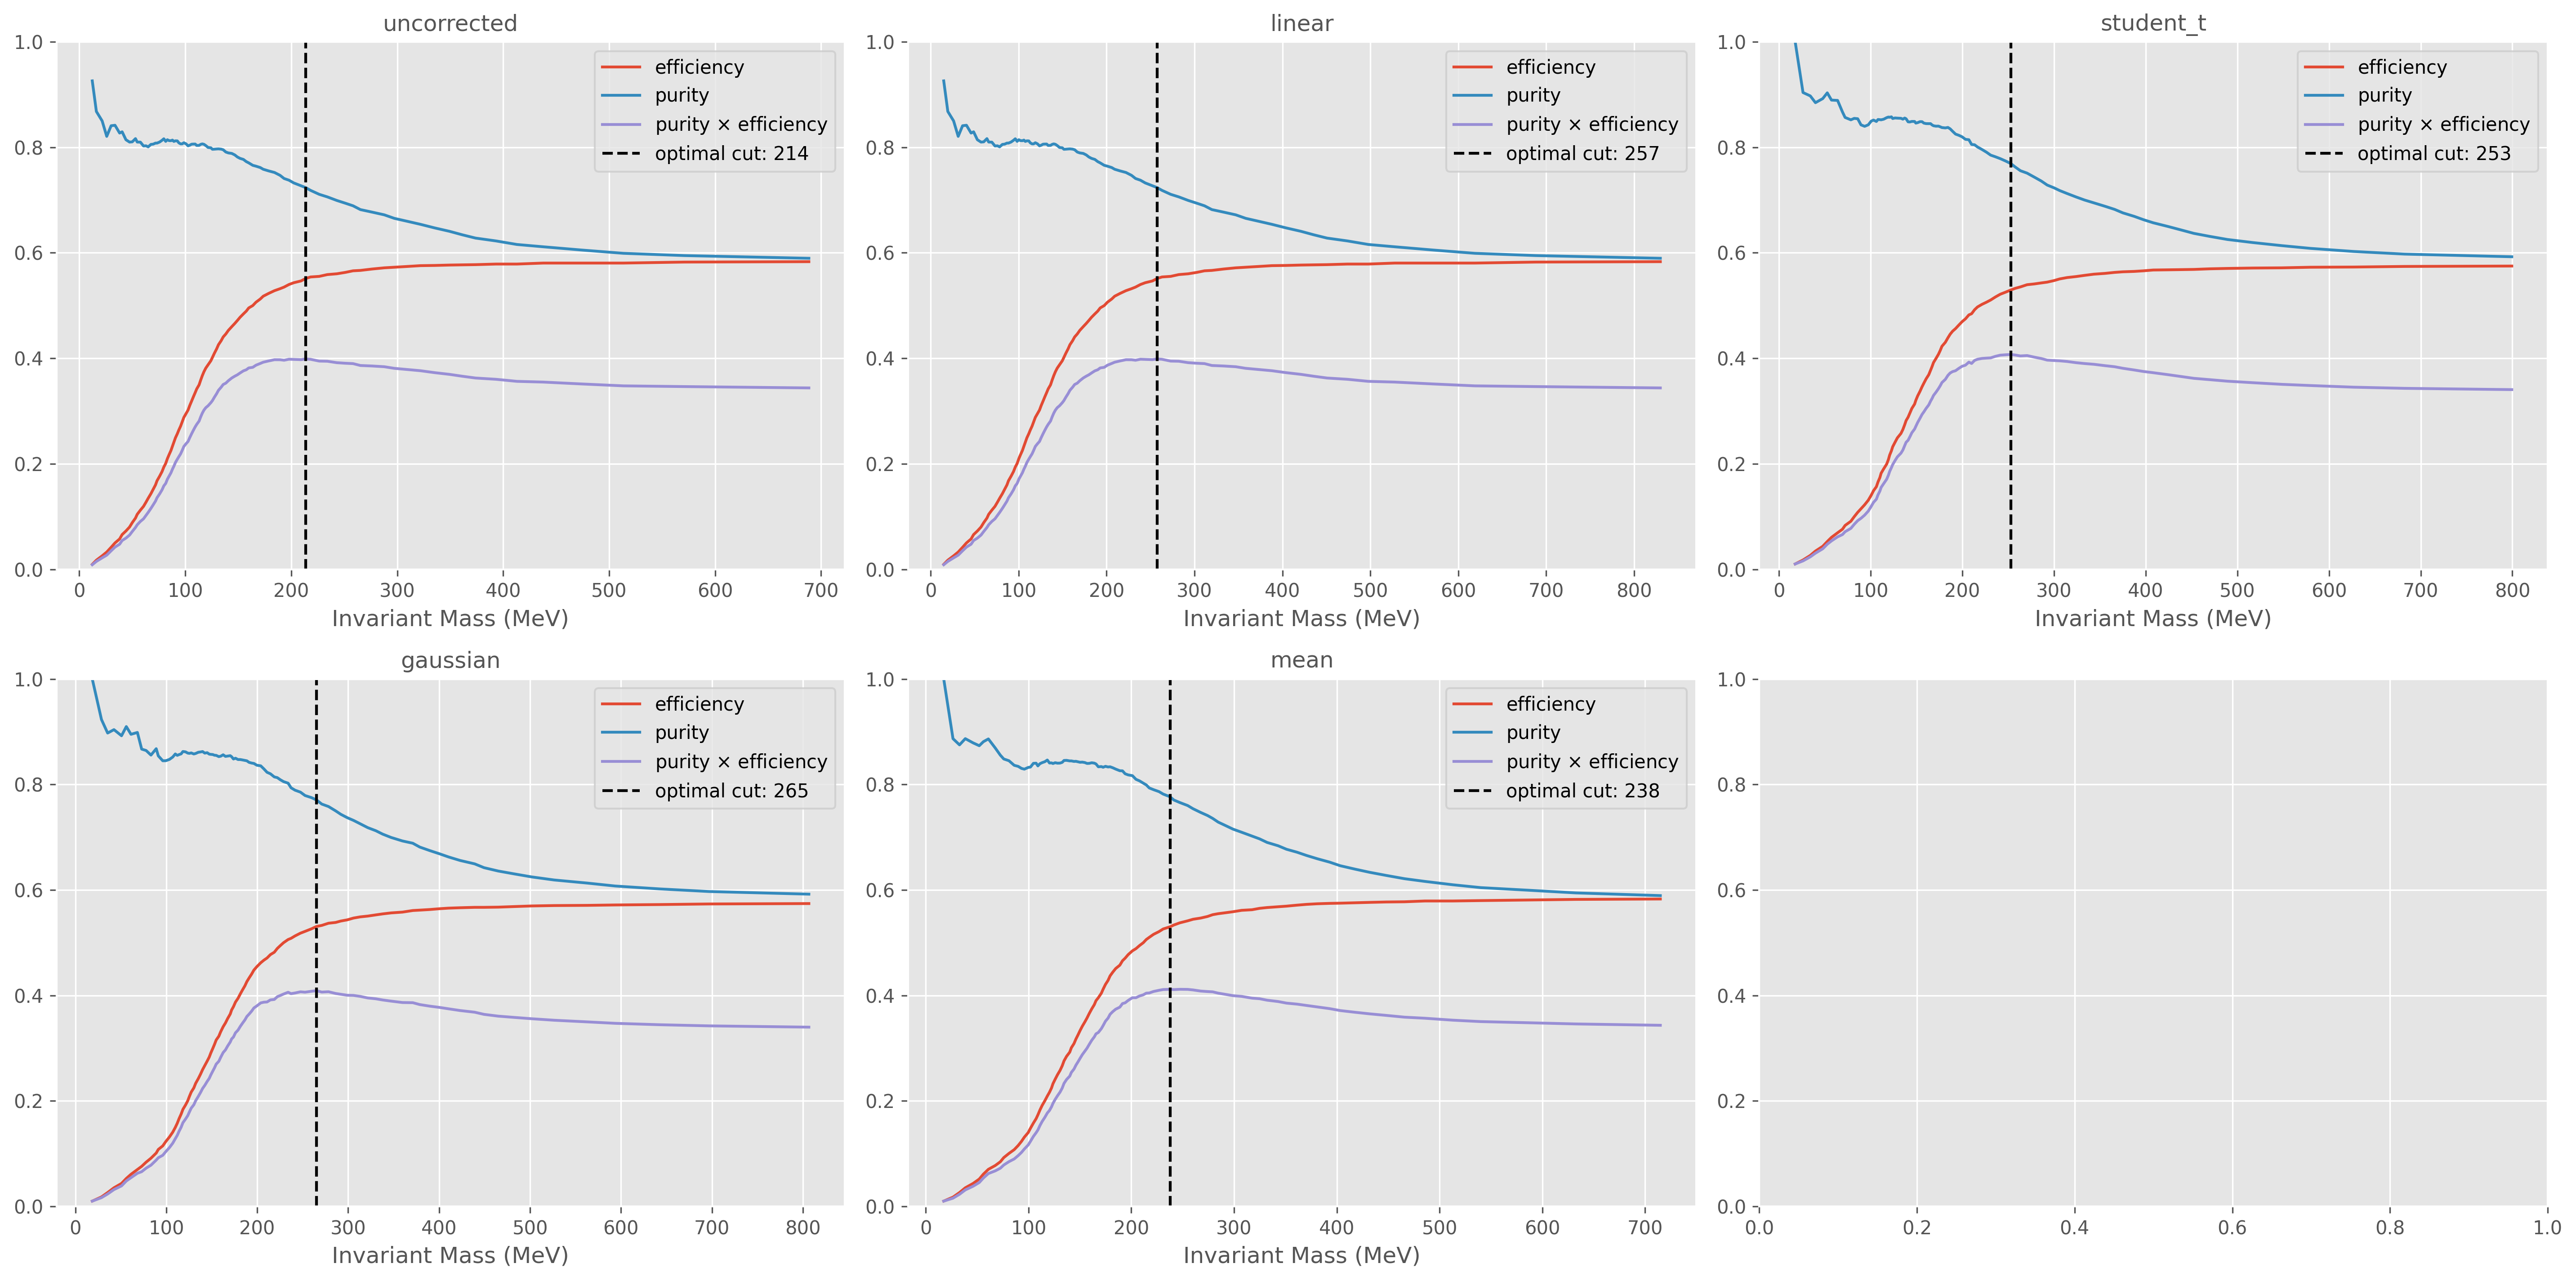

In [81]:
dims = figure_dimensions(len(mass))
plt.subplots(dims[0], dims[1], figsize = [6.4 * dims[1], 4.8 * dims[0]])
for i, m in enumerate(mass):
    plt.subplot(dims[0], dims[1], i + 1)
    optimal_cut(mass[m], pi0_tags.name_simple["pi0s"].mask, True)
    plt.xlabel("Invariant Mass (MeV)")
    plt.title(m)
if save: Plots.Save("optimal_cuts", path)


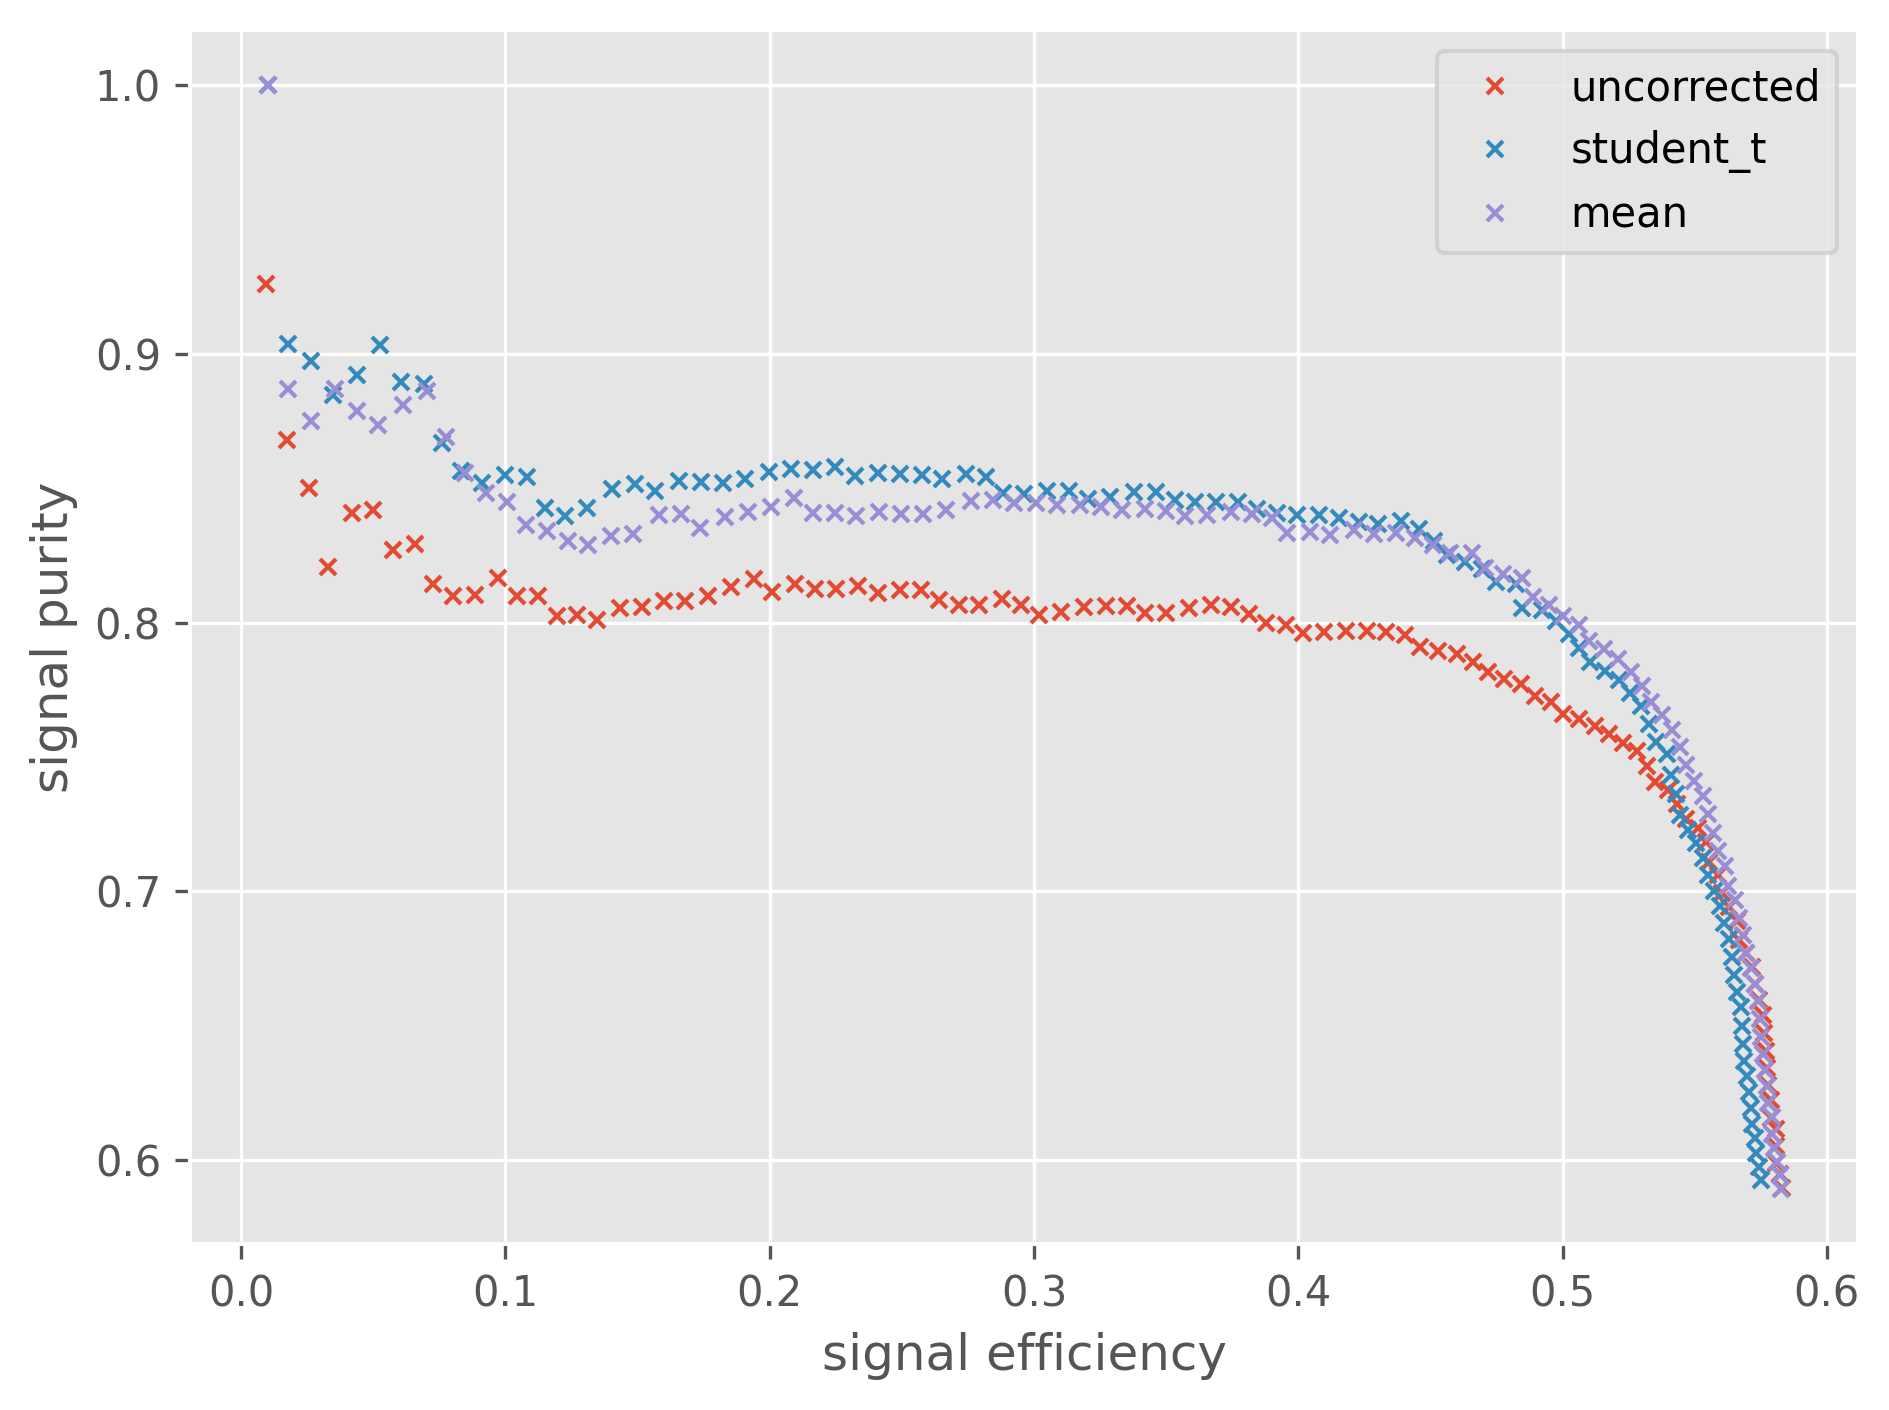

In [71]:
plt.figure()
for m in mass:
    if m in ["linear", "gaussian"]: continue
    e, p, sy, by, cuts = cut_scan(mass[m], pi0_tags.name_simple["pi0s"].mask)
    Plots.Plot(e, p, marker = "x", label = m, xlabel = "signal efficiency", ylabel = "signal purity", markersize = 4, newFigure = False, linestyle="")


n_signal=1555

n_background=1101

sorted_ind=array([1246, 1087, 1831, ..., 1682,   43, 2548])

315 1193 0.7911140583554377 0.7672025723472669 139.40243555740642

n_signal=1555

n_background=1101

sorted_ind=array([1246, 1087, 2174, ..., 1234, 2597, 2563])

315 1302 0.8051948051948052 0.8372990353697749 212.2698468812607

n_signal=1555

n_background=1101

sorted_ind=array([1246, 1087, 2174, ..., 1682,   43, 2548])

315 1314 0.8066298342541437 0.845016077170418 208.2824540868447

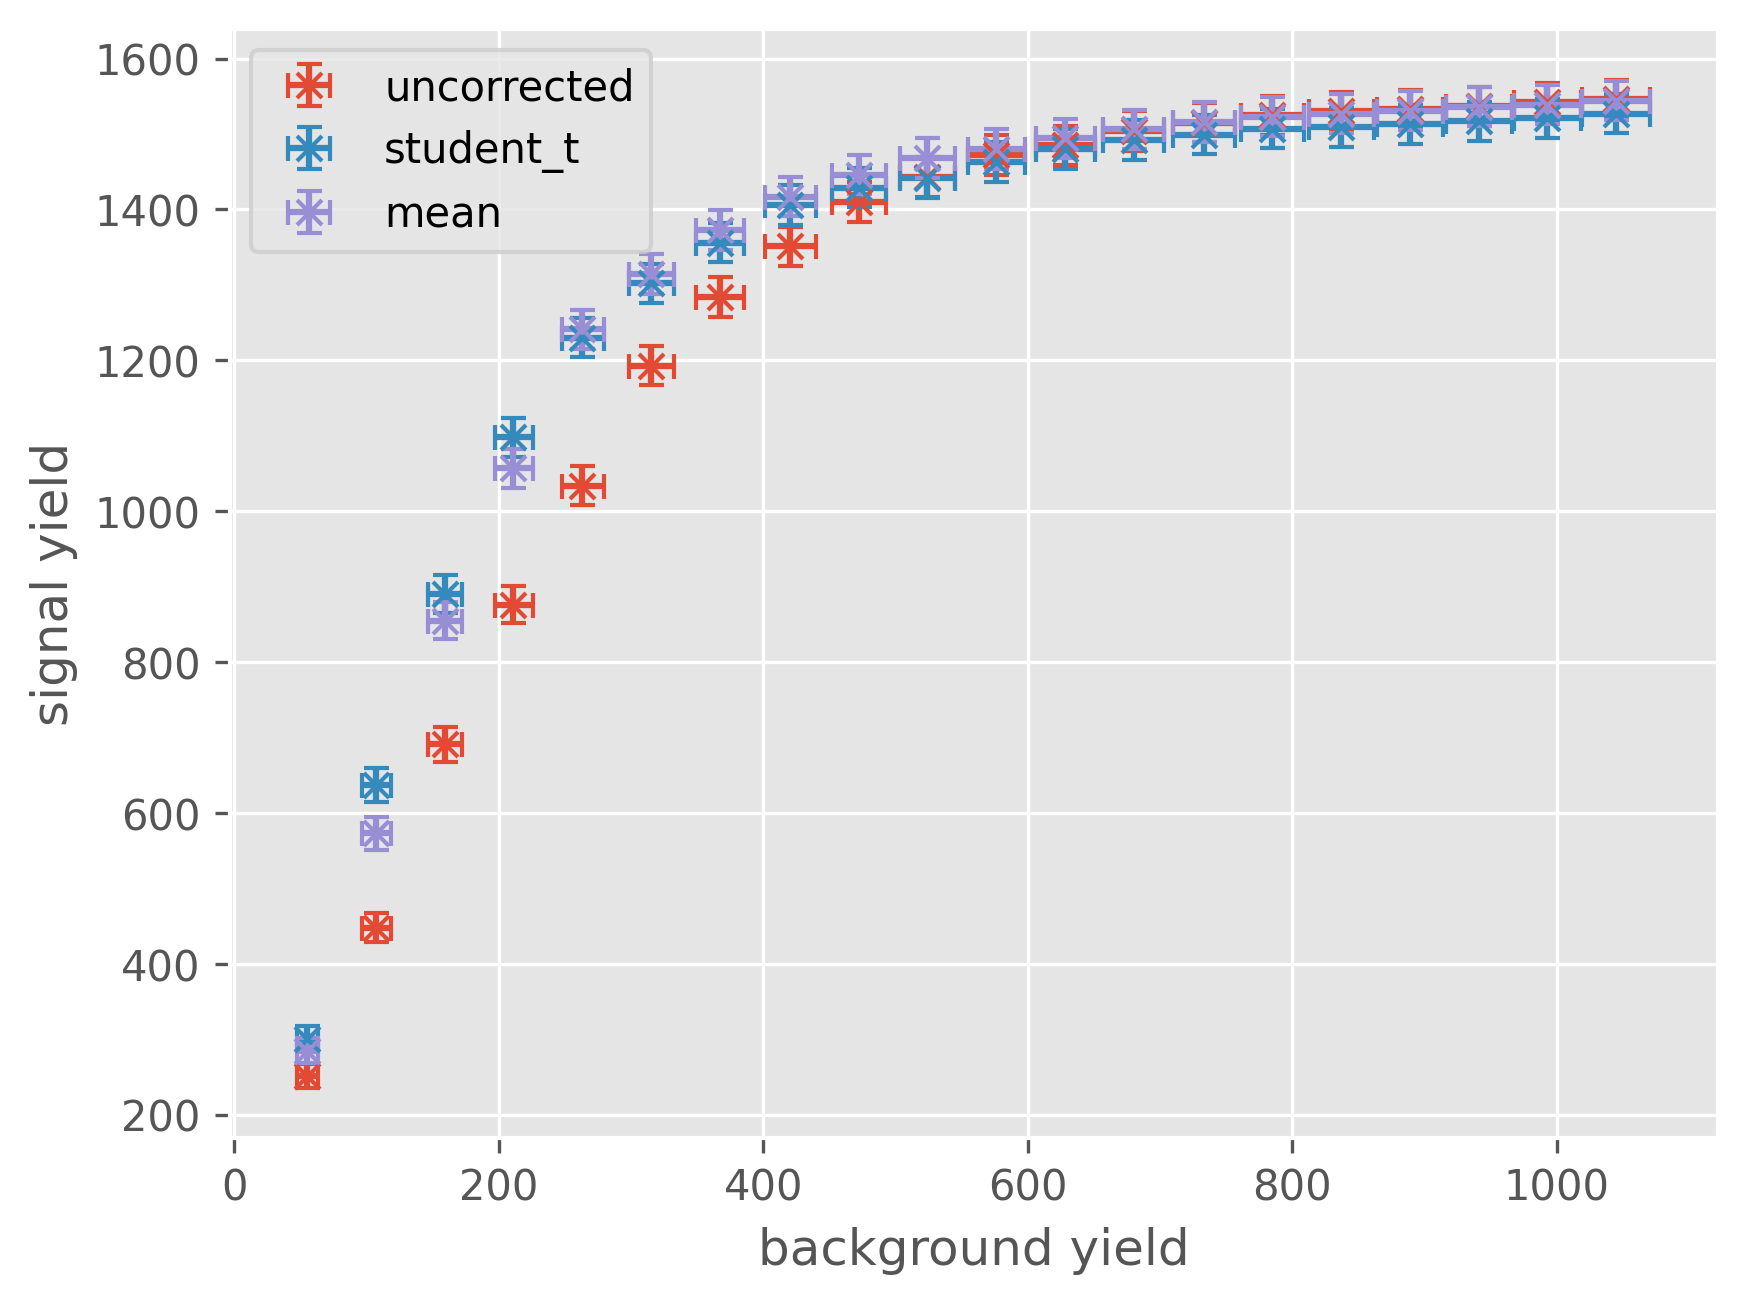

In [79]:
import statsmodels.api as sm
def optimal_cut_yield(value : np.array, signal_mask : np.array):
    n_signal = np.sum(signal_mask)
    n_background = np.sum(~signal_mask)
    print(f"{n_signal=}")
    print(f"{n_background=}")

    sorted_ind = np.argsort(np.array(value))
    sorted_value = np.array(value[sorted_ind])
    sorted_mask = np.array(signal_mask[sorted_ind])
    print(f"{sorted_ind=}")

    # bkg_yields = np.linspace(0, n_background-1, 20, dtype = int)

    bkg_yields = np.array(n_background * np.linspace(0.05, 0.95, 20), dtype = int)

    sig_yields = []
    cuts = []

    purity = []
    efficiency = []

    for y in bkg_yields:
        cut_value = sorted_value[~sorted_mask][y]
        cuts.append(cut_value)
        sig_yields.append(np.sum(signal_mask[value < cut_value]))

        purity.append(np.sum(signal_mask[value < cut_value]) / len(signal_mask[value < cut_value]))
        efficiency.append(np.sum(signal_mask[value < cut_value]) / n_signal)

    return bkg_yields, sig_yields, purity, efficiency, cuts

plt.figure()
for m in mass:
    if m in ["linear", "gaussian"]: continue
    by, sy, p, e, cuts = optimal_cut_yield(mass[m], pi0_tags.name_simple["pi0s"].mask)

    # trials = 141548
    trials = len(pi0_tags.name_simple["pi0s"].mask)
    s_error = abs(sy - trials * np.array(sm.stats.proportion_confint(sy, trials, 1 - 0.6827, method = "beta")))
    b_error = abs(by - trials * np.array(sm.stats.proportion_confint(by, trials, 1 - 0.6827, method = "beta")))

    # byf = by / np.sum(~pi0_tags.name_simple["pi0s"].mask)
    # syf = sy / np.sum(pi0_tags.name_simple["pi0s"].mask)

    # byf_error = b_error / np.sum(~pi0_tags.name_simple["pi0s"].mask)
    # syf_error = s_error / np.sum(pi0_tags.name_simple["pi0s"].mask)

    plt.errorbar(x = by, y = sy, xerr = b_error, yerr = s_error, capsize = 3, linestyle = "", marker = "x", markersize = 6, label = m)
    plt.ylabel(f"signal yield")
    plt.xlabel(f"background yield")
    
    # plt.ylabel(f"signal yield (total : {np.sum(pi0_tags.name_simple['pi0s'].mask)})")
    # plt.xlabel(f"background yield (total : {np.sum(~pi0_tags.name_simple['pi0s'].mask)})")
    plt.legend()

    chosen = 5
    print(by[chosen], sy[chosen], p[chosen], e[chosen], cuts[chosen])

    # Plots.Plot(by, sy, label = m, newFigure = False)

In [67]:
print(pi0_tags)

for m in pi0_tags.mask.values:
    print(np.sum(m))

{
    "2 $\\gamma$'s, same $\\pi^{0}$": Tag(
        name="2 $\\gamma$'s, same $\\pi^{0}$",
        name_simple='pi0s',
        colour=None,
        mask=<Array [True, False, False, ... False, False] type='2656 * ?bool'>,
        number=0
    ),
    '2 $\\gamma$s, different $\\pi^{0}$': Tag(
        name='2 $\\gamma$s, different $\\pi^{0}$',
        name_simple='different mother',
        colour=None,
        mask=<Array [False, False, True, ... True, True] type='2656 * ?bool'>,
        number=1
    ),
    '1 $\\gamma$': Tag(
        name='1 $\\gamma$',
        name_simple='one photon',
        colour=None,
        mask=<Array [False, True, False, ... False, False] type='2656 * bool'>,
        number=2
    ),
    '0 $\\gamma$': Tag(
        name='0 $\\gamma$',
        name_simple='no photons',
        colour=None,
        mask=<Array [False, False, False, ... False, False] type='2656 * bool'>,
        number=3
    )
}

1555

636

413

52

In [ ]:
# import json

# params = {}
# params["linear_correction_params"] = {"p0" : linear_correction}
# params["response_mean_correction_params"] = {f"p{i}" : popt_mean[i] for i in range(len(popt_mean))}
# params["response_student_t_correction_params"] = {f"p{i}" : popt_fit[i] for i in range(len(popt_fit))}

# for name, p in params.items():
#     with open(path + name + ".json", "w") as f:
#         json.dump(p, f)
